# Исследование приложения Procrastinate Pro+

Предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года, для развлекательного приложения Procrastinate Pro+. Компания последние несколько месяцев теряет доходы. Необходимо проанализировать причины убытков компании за последние несколько месяцев и помочь компании на основе проведённого анализа выйти в плюс.

<font size=+1><b>Описание данных:</b></font><br>
В основных данных есть информация о пользователях, их заказах и рекламных компаниях за данных период.

<font size=+0.5><b>Пользователи</b></font><br>
Данные о пользователях visits_info_short_project.csv
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

<font size=+0.5><b>Заказы</b></font><br>
Данные о заказах, совершённых пользователями orders_info_short.csv
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

<font size=+0.5><b>Рекламные компании</b></font><br>
Данные о проведённых рекламных компаниях costs_info_short.csv
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

<font size=+1><b>План работы:</b></font><br>
- Загрузить и изучить данные
- Найти и изучить пропуски в данных и дубликаты
- Составить профили пользователей
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей
- Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи
- Изучить рекламные источники привлечения и определить каналы, из которых пришло больше всего платящих пользователей
- Посчитать общую сумму расходов на маркетинг
- Выяснить, как траты распределены по рекламным источникам
- Посмотреть динамику изменения расходов во времени по неделям и месяцам по каждому источнику.
- Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника
- Используя графики LTV, ROI и CAC, проанализировать окупаемость рекламы. Считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.
- Проанализировать окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверить конверсию пользователей и динамику её изменения.
- Проверить конверсию удержания пользователей и динамику её изменения.
- Проанализировать окупаемость рекламы с разбивкой по устройствам. 
- Проанализировать окупаемость рекламы с разбивкой по странам.
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам.
- Выяснить: 
    - окупается ли реклама, направленная на привлечение пользователей в целом
    - какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы
    - чем могут быть вызваны проблемы окупаемости
- Описать причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела
- Выделить причины неэффективности привлечения пользователей.
- Сформулировать рекомендации для отдела маркетинга.

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Цветовая палитра графиков
cmap_table='coolwarm'
cmap_table2='Blues'

In [3]:
# функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset)
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient(cmap_table))
    print('---------------------------------')
    display('Основная информация по таблице:')
    display(data.describe().style.format('{:.1f}'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для создания сводной таблицы с долей платящих для разных категорий
def category_payer(data, col_group, values='payer'):
    return data.groupby(col_group, as_index=False)\
               .agg(total = (values, 'count'),
                    payer_share = (values, 'mean'))\
               .sort_values(by='payer_share', ascending=False)\
               .style.format({'payer_share': '{:.1%}'})\
               .background_gradient(cmap_table2) 

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для создания пользовательских профилей

In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                        .groupby('user_id')
                        .agg({'session_start': 'first',
                              'channel': 'first',
                              'device': 'first',
                              'region': 'first'})
                        .rename(columns={'session_start': 'first_ts'})
                        .reset_index())

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['dt', 'channel'])
                         .agg({'user_id': 'nunique'})
                         .rename(columns={'user_id': 'unique_users'})
                         .reset_index())

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],
                              on=['dt', 'channel'],
                              how='left')

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания

In [7]:
# функция для расчёта удержания

def get_retention(profiles,
                  sessions,
                  observation_date,
                  horizon_days,
                  dimensions=[],
                  ignore_horizon=False):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date \
                                         - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], 
                                  on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts'])\
                             .dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', 
                                values='user_id', aggfunc='nunique')
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии

In [8]:
# функция для расчёта конверсии

def get_conversion(profiles,
                   purchases,
                   observation_date,
                   horizon_days,
                   dimensions=[],
                   ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date \
                                         - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
                                .groupby('user_id')
                                .agg({'event_dt': 'first'})
                                .reset_index())

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], 
                                  on='user_id', how='left')

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts'])\
                             .dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', 
                                values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, 
                                         dimensions + ['dt'], 
                                         horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта LTV и ROI

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(profiles,
            purchases,
            observation_date,
            horizon_days,
            dimensions=[],
            ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date \
                                         - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], 
                                  on='user_id', how='left')
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts'])\
                             .dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', 
                                values='revenue', aggfunc='sum')
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (cac.groupby(dims)
                  .agg({'acquisition_cost': 'mean'})
                  .rename(columns={'acquisition_cost': 'cac'}))

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(result_raw, 
                                                      dimensions, 
                                                      horizon_days)

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(result_raw, 
                                                      dimensions + ['dt'], 
                                                      horizon_days)

    return (result_raw,  # сырые данные
            result_grouped,  # таблица LTV
            result_in_time,  # таблица динамики LTV
            roi_grouped,  # таблица ROI
            roi_in_time)  # таблица динамики ROI

#### Функция для сглаживания фрейма

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации удержания

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 8))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_history.index.names
               if name not in ['dt', 'payer']]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True')\
                                     .pivot_table(index='dt', columns=columns, 
                                                  values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False')\
                                     .pivot_table(index='dt', columns=columns, 
                                                  values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

#### Функция для визуализации конверсии

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 8))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt', columns=columns, 
                                                   values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, 
                                            values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, 
                                            values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, 
                                            values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Загрузка данных  и основная информация

#### Пользователи

Посмотрим на основную информацию из таблицы о пользователях.

In [14]:
visits = main_info('visits_info_short.csv')

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице содержится 6 столбцов и 309301 записей с данными о пользователях.
- В таблице нет пропущенных значений и явных дубликатов.
- Тип данных столбцах с датами необходимо будет исправить на корректный.

#### Заказы

Посмотрим на основную информацию в таблице с заказами.

In [15]:
orders = main_info('orders_info_short.csv')

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице содержится 3 столбца и 40212 записей с данными о заказах.
- В таблице нет пропущенных значений и явных дубликатов.
- Тип данных столбце с датой необходимо будет исправить на корректный.

#### Рекламные компании

Посмотрим на основную информацию в таблице с рекламными компаниями.

In [16]:
costs = main_info('costs_info_short.csv')

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

---------------------------------


'Основная информация по таблице:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

- В таблице содержится 3 столбца и 1800 записей с данными о рекламных компаниях.
- В таблице нет пропущенных значений и явных дубликатов.
- Тип данных столбце с датой необходимо будет исправить на корректный.

### Промежуточные выводы:

Было загружено три датасета с информацией о пользователях, их заказах и рекламных компаниях.
- В таблице с пользователями содержится 6 столбцов и 309301 записей.
- В таблице с заказами содержится 3 столбца и 40212 записей.
- В таблице с рекламными компаниями содержится 3 столбца и 1800 записей.
- В таблицах нет пропущенных значений и явных дубликатов.
- Тип данных столбцах с датами необходимо будет исправить на корректный.

## Предобработка данных

Ни в одной из таблиц не было пропущенных значений, также не было и явных дубликатов. Проверим наличие неявных дубликатов в столбцах с категориальными данными.

In [17]:
print('Регионы: ', visits['Region'].unique())
print('Устройства: ', visits['Device'].unique())
print('Каналы привлечения, посещения: ', visits['Channel'].unique())
print('Каналы привлечения, хост: ', costs['Channel'].unique())

Регионы:  ['United States' 'UK' 'France' 'Germany']
Устройства:  ['iPhone' 'Mac' 'Android' 'PC']
Каналы привлечения, посещения:  ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
Каналы привлечения, хост:  ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


В данных присутствуют 4 уникальных региона, 4 уникальных девайса, 11 уникальных каналов привлечения пользователей. При этом каналы привлечения пользователей у нас есть и для таблицы с посещениями пользователей и для таблицы с заказами. Проверим их пересечения между собой.

In [18]:
list(set(costs['Channel'].unique()) ^ set(visits['Channel'].unique()))  

['organic']

Пересечения нет только для канала органических пользователей. Можно отметить, что этот канал пользователей означает, что они пришли в приложение сами, без каких-то рекламных ссылок. Поэтому он не учтён в таблице с затратами на рекламные компании.

Изменим тип данных в таблицах с датой для удобства работы с этими столбцами.

In [19]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Приведём название столбцов согласно принятому стилю.

In [20]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

### Промежуточные выводы:

- Загружено 3 датасета. 
- Ни в одной из таблиц нет пропусков данных или явных дубликатов.
- Столбцы с датами были приведены к правильному типу данных.
- Название столбцов было приведено к принятому стилю.
- Данные подготовлены для дальнейшего анализа.

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей по данным сессий из датафрейма visits:

In [21]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt    month  payer  acquisition_cost  
0  2019-05-07  2019-05   True          1.088172  
1  2019-07-09  2019-07  False          1.107237  
2  2019-10-01  2019-10  False          0.000000  
3  2019-08-22  2019-08  False          0.988235  
4  2019-10-02  2019-10  False          0.230769

In [22]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  period[M]     
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(4), period[M](1)
memory usage: 9.3+ MB


Результат - 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения, регионе, устройстве и рекламном источнике, который мотивировал пользователя посетить приложение. А также пользователи разбиты по их тратам в приложении.

Определим минимальную и максимальную дату привлечения пользователей:

In [23]:
print('Минимальная дата привлечения пользователей: ', profiles['dt'].min())
print('Максимальная дата привлечения пользователей: ', profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


Минимальной датой привлечения пользователя является 1 мая 2019 г, а максимальной - 27 октября 2019 г. Эти даты сходятся с датами, которые были в условиях поставленной задачи.

### Страны пользователей

Посмотрим на страны пользователей, которые приходят в приложение:

In [24]:
category_payer(profiles, 'region')

Больше всего и пользователей (почти 50% из всех пользователей приложения) и платящих (почти 7%) из США. То есть, основным рынком можно назвать именно эта страну, так как оттуда больший приток пользователей, и эти пользователи показывают наибольший переход в покупатели. На втором месте по платящим находится Германия, хотя пользователей приложения в ней меньше всего. Третье/ четвёртое место делят Великобритания и Франция. И количество пользователей и доля платящих в них примерно одинакова.

### Устройства пользователей

Посмотрим на устройства пользователей, с которых они входят в приложение:

In [25]:
category_payer(profiles, 'device')

Наиболее популярное устройство среди пользователей - айфон, при этом среди платящих он всего на втором месте. Но, можно сказать, что первое/ второе место по доле платящих делят пользователи Мака и айфона с 6.4% и 6.2%, соответственно. Пользователи андроида занимают второе место по количеству и третье место по доле платящих с 5.9%. Последнее место по популярности среди платящих занимают пользователи ПК с 5%.

### Каналы привлечения

Посмотрим на рекламные источники привлечения новых пользователей:

In [26]:
category_payer(profiles, 'channel', 'payer')

В тройке лидеров каналов по привлечению новых платящих пользователей находятся: FaceBoom, AdNonSense и lambdaMediaAds. При этом количество привлечённых пользователей больше по каналу organic, но он занимает последнее место по доле платящих пользователей. Меньше 5% платящих пользователей приходятся на такие каналы, как YRabbit, MediaTornado, LeapBob и OppleCreativeMedia. И это при том, что общее количество пользователей для этих каналов довольно неплохое.

### Промежуточные выводы:

- Больше всего пользователей приходится на США (почти 50% пользователей приложения). 
- В США больше всего платящих пользователей - 7%, а в других странах около 4%.
- Самое популярное устройство среди пользователей - айфон.
- Самое популярное устройство среди платящих пользователей - мак с 6.4%, айфон находится на втором месте с 6.2%, а на последнем - ПК с 5%.
- Наиболее популярный канал привлечения organic, но доля платящих пользователей по этому каналу самая низкая.
- Второй по популярности и первый среди платящих пользователей канал привлечения - FaceBoom.
- Лидерами по привлечению платящих пользователей являются каналы FaceBoom, AdNonSense и lambdaMediaAds с конверсией пользователей в платящих выше 10%.
- Меньше 5% платящих пользователей приходятся на каналы YRabbit, MediaTornado, LeapBob и OppleCreativeMedia.

## Маркетинг

Посчитаем общую сумму расходов на маркетинг за всё время:

In [27]:
print('Общая сумма расходов на маркетинг: ', 
      round(costs['costs'].sum(), 1))

Общая сумма расходов на маркетинг:  105497.3


Общая сумма расходов на маркетинг составила почти 105 тыс.

### Распределение денег на каждый источник

Оценим, сколько денег потратили на каждый источник:

In [28]:
result = table_pivot(data=costs, col_group='channel', values='costs', func='sum')
result['share_costs'] = result['total'] / result['total'].sum()
result.sort_values(by='share_costs', ascending=False)\
      .style.format({'total': '{:.1f}', 'share_costs': '{:.1%}'})\
      .background_gradient(cmap_table2) 

Больше всего средств потратили на канал TipTop (почти 52% от общих средств), но при этом доля платящих пользователей по этому каналу находится всего на четвёртом месте. Вторым по затраченным средствам является канал FaceBoom - почти 31% потраченных средств, и доля платящих пользователей по этому каналу находится на первом месте. На все остальные каналы было потрачено в разы меньше денег, суммарно около 18% на все остальные источники привлечения пользователей. Таким образом, стоит обратить внимание на два канала: TipTop и FaceBoom, так как на них суммарно было потрачено 82% от всех средств.

### Динамика изменения расходов во времени для каждого источника

Посмотрим на динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [29]:
costs['month'] = pd.DatetimeIndex(costs['dt']).month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

Создадим сводные таблицы для трат по месяцам и неделям для разных каналов привлечения пользователей.

In [30]:
month_costs = costs.groupby(['channel', 'month'], as_index=False)\
                   .agg(total = ('costs', 'sum'),
                        mean_costs = ('costs', 'mean'))
week_costs = costs.groupby(['channel', 'week'], as_index=False)\
                  .agg(total = ('costs', 'sum'),
                       mean_costs = ('costs', 'mean'))

Построим графики динамики изменений расходов по неделям и месяцам для каждого источника.

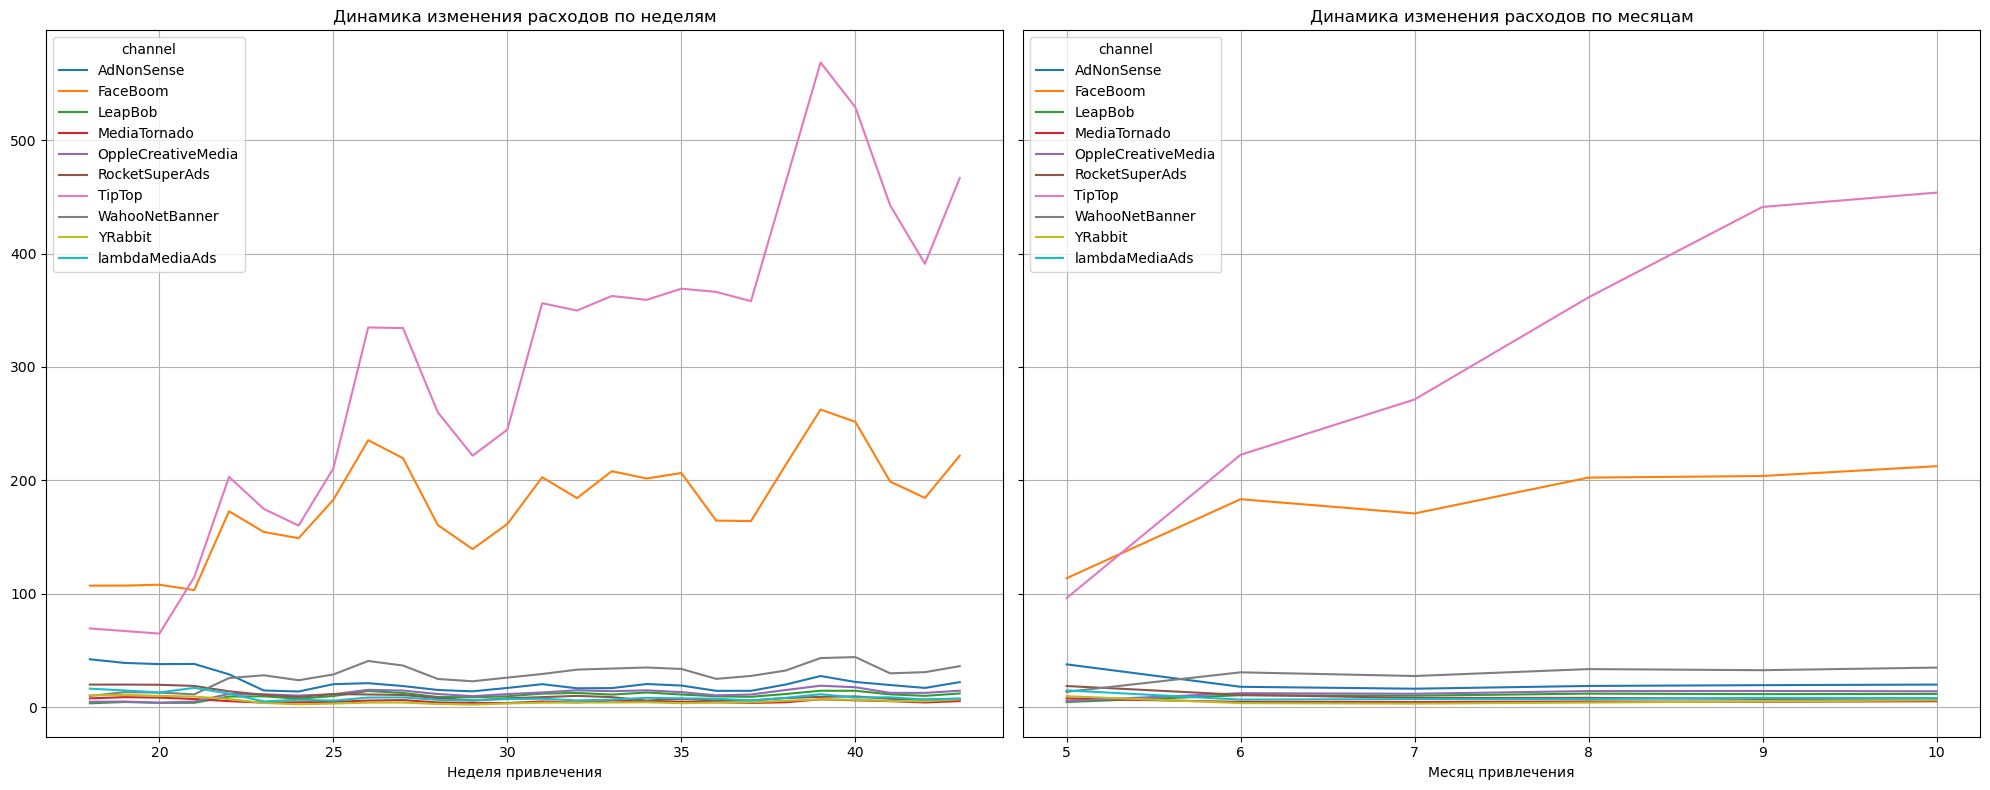

In [31]:
plt.figure(figsize=(20, 8))
# первый график — динамика изменения расходов по неделям
ax1 = plt.subplot(1, 2, 1)
filtered_data = week_costs.pivot_table(index='week', 
                                       columns='channel', 
                                       values='mean_costs')
window = 1
filter_data(filtered_data, window).plot(grid=True, ax=ax1)

plt.xlabel('Неделя привлечения')
plt.title('Динамика изменения расходов по неделям')

# второй график — динамика изменения расходов по месяцам
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
filtered_data = month_costs.pivot_table(index='month', 
                                        columns='channel', 
                                        values='mean_costs')
filter_data(filtered_data, window).plot(grid=True, ax=ax2)

plt.xlabel('Месяц привлечения')
plt.title('Динамика изменения расходов по месяцам')

plt.tight_layout()
plt.show() 

Как видно из графиков динамики изменения расходов привлечения пользователей, подвержены изменениям были только каналы TipTop и FaceBoom. Для всех остальных каналов изменений практически нет. Можно отметить более резкий рост и сильные колебания по неделям привлечений для канала TipTop. Канал FaceBoom ведёт себя более стабильно: плавное повышение с мая по август, небольшая просадка в июле, а дальше - практически на одном уровне находились расходы для этого канала.

Посмотрим на динамику набора новых пользователей по каналам.

### Стоимость привлечения одного пользователя для каждого источника

Посчитаем стоимость привлечения одного пользователя из каждого источника. Для этого создадим сводную таблицу.

In [32]:
cac_user = profiles.groupby(by='channel', as_index=False)\
                   .agg(total_user = ('user_id', 'count'),
                        count_payer = ('payer', 'sum'),
                        acquisition_cost_mean = ('acquisition_cost', 'mean'))                              

cac_user['share_payer'] = cac_user['count_payer'] / cac_user['total_user']
cac_user.sort_values(by=('share_payer'), ascending=False)\
        .style.format({'acquisition_cost_mean': '{:.1f}',
                       'share_payer': '{:.1%}'})\
        .background_gradient(cmap_table2) 

Наибольшая стоимость привлечения одного пользователя для канала TipTop - 2.8, при этом количество платящих пользователей для этого канала занимает только второе место, а по проценту платящих среди всех пользователей от этого канала - четвёртое место.

Второе место по стоимости привлечения для канала FaceBoom - 1.1, что меньше первого места более, чем в 2 раза. При этом, этот канал находится на первом месте по доле платящих пользователей.

Третье место по стоимости привлечения занимает канал AdNonSense с 1, при этом доля платящих пользователей для этого канала находится на втором месте с 11.3%.

Наименьшая стоимость привлечения для канала LeapBob, но и по доле платящих пользователей этот канал находится на последних местах. Также можно отметить отсутствие стоимости привлечения с канала organic, поэтому в дальнейших вычислениях можно его не учитывать. Ведь затрат на этот канал не было, а пользователи с этого канала будут занижать показатели по другим источникам, которые нам необходимо проанализировать.

### Промежуточные выводы:

- Больше всего средств было потрачено на канал TipTop, следующее место занимает канал FaceBoom, на все остальные каналы было потрачено в разы меньше денег.
- Наибольшая стоимость привлечения одного пользователя для канала TipTop, но при этом процент платящих пользователей для этого канала находится на четвёртом месте.
- Наибольшая доля платящих пользователей для канала FaceBoom, при этом стоимость привлечения одного пользователя для этого канала находится на втором месте.
- На третьем месте по средней стоимости привлечения пользователя находится канал AdNonSense, а для всех остальных каналов средняя стоимость привлечения составляет меньше 1.
- Наименьшая стоимость привлечения для канала LeapBob, а по проценту платящих этот канал находится на пятом месте.
- Динамике изменения расходов подвержены изменениям были только каналы TipTop и FaceBoom (наблюдается рост с каждым месяцем), для остальных каналов изменений практически нет.

Таким образом можно отметить, что канал TipTop вызывает вопросы, так как финансирование привлечения пользователей для данного канала составляет более 50% от всех остальных каналов, и при этом средняя стоимость привлечения пользователей для него самая высокая - 2.8, в то время, как для второго по средней стоимости канала FaceBoom это значение составило всего 1.1. К тому же динамика расходов на этот канал сильно растёт по месяцам. Да и процент платящих пользователей для канала TipTop находится только на четвёртом месте и проигрывает другим каналам.

## Оценка окупаемости рекламы

### Окупаемость рекламы по разным метрикам

Предположим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [33]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Исключим пользователей с органическим трафиком, так как стоимость привлечения пользователей для этого источника равна нуля, а нам нужно оценить окупаемость рекламы и выявить сильные и слабые каналы привлечения.



In [34]:
profiles = profiles.query('channel != "organic"')

Приступим к анализу показателей. Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV, CAC и ROI.

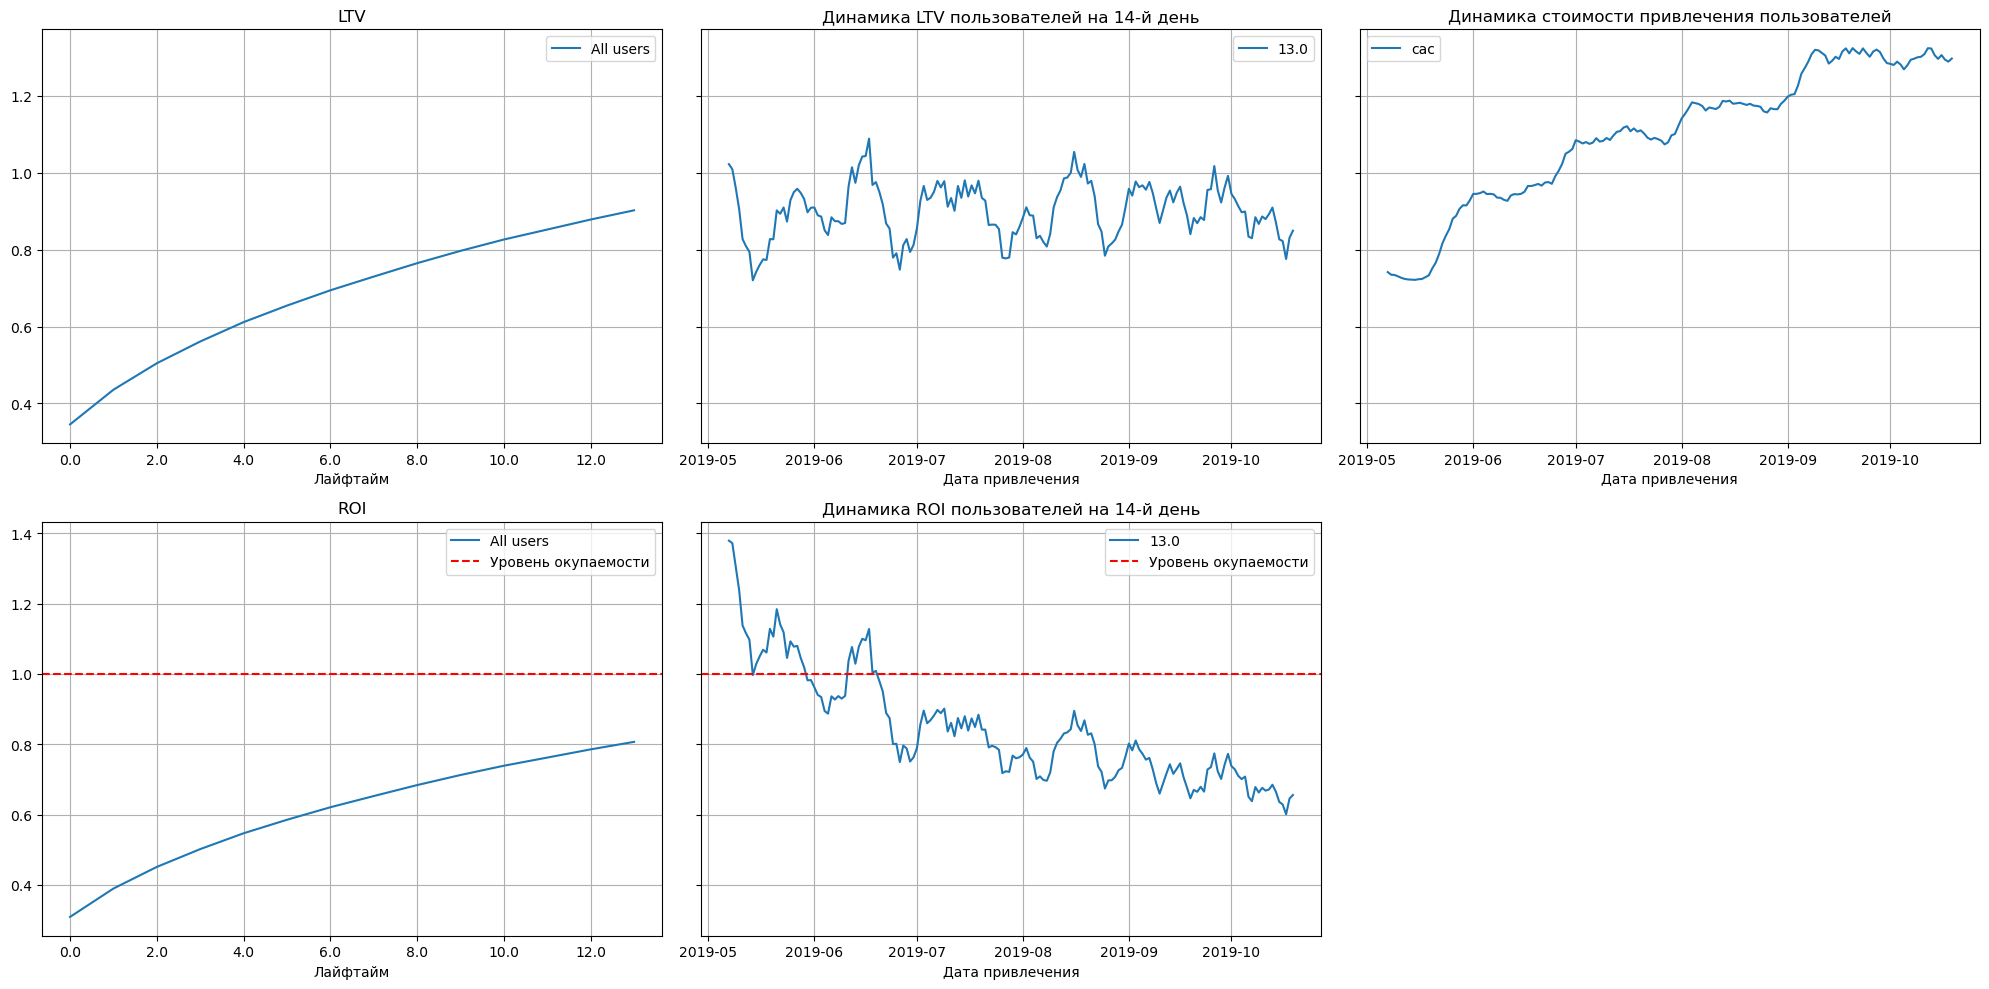

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков видно, что:
- LTV плавно растёт на протяжении всего лайфтайма (первой недели после регистрации), но к концу лайфтайма он приблизился только к 90%.
- Если посмотреть на динамику LTV пользователей на 14-й день привлечения, то особых отличий по месяцам нет. Разве что наблюдается самая большая просадка в середине мая. Таким образом, можно предположить, что дело не в ухудшении качества пользователей.
- CAC претерпел наибольшее увеличение с мая по июнь, а далее каждый месяц в течение месяца находится на относительной планке по значениям и с началом следующего месяца возрастает. Можно отметить, что роста значений не было только в октябре - значения остались на уровне сентября. 
- Рост CAC означает, что расходы на привлечение одно клиента возрастали каждый месяц. На этот показатель стоит обратить внимание более подробно.
- При этом ROI в конце лайфтайма только приблизился к 80%, что означает, что реклама не окупается.
- Если посмотреть на динамику ROI в конце двух недель по дате привлечения, то можно отметить, что этот показатель с каждым месяцем стабильно снижается. Причём, после середины июня показатель опустился ниже значения окупаемости и бльше её не пересекал ни разу.

Чтобы разобраться в причинах, необходимо пройти по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Конверсия и удержание пользователей

Посмотрим на конверсию и динамику этого показателя для всех пользователей.

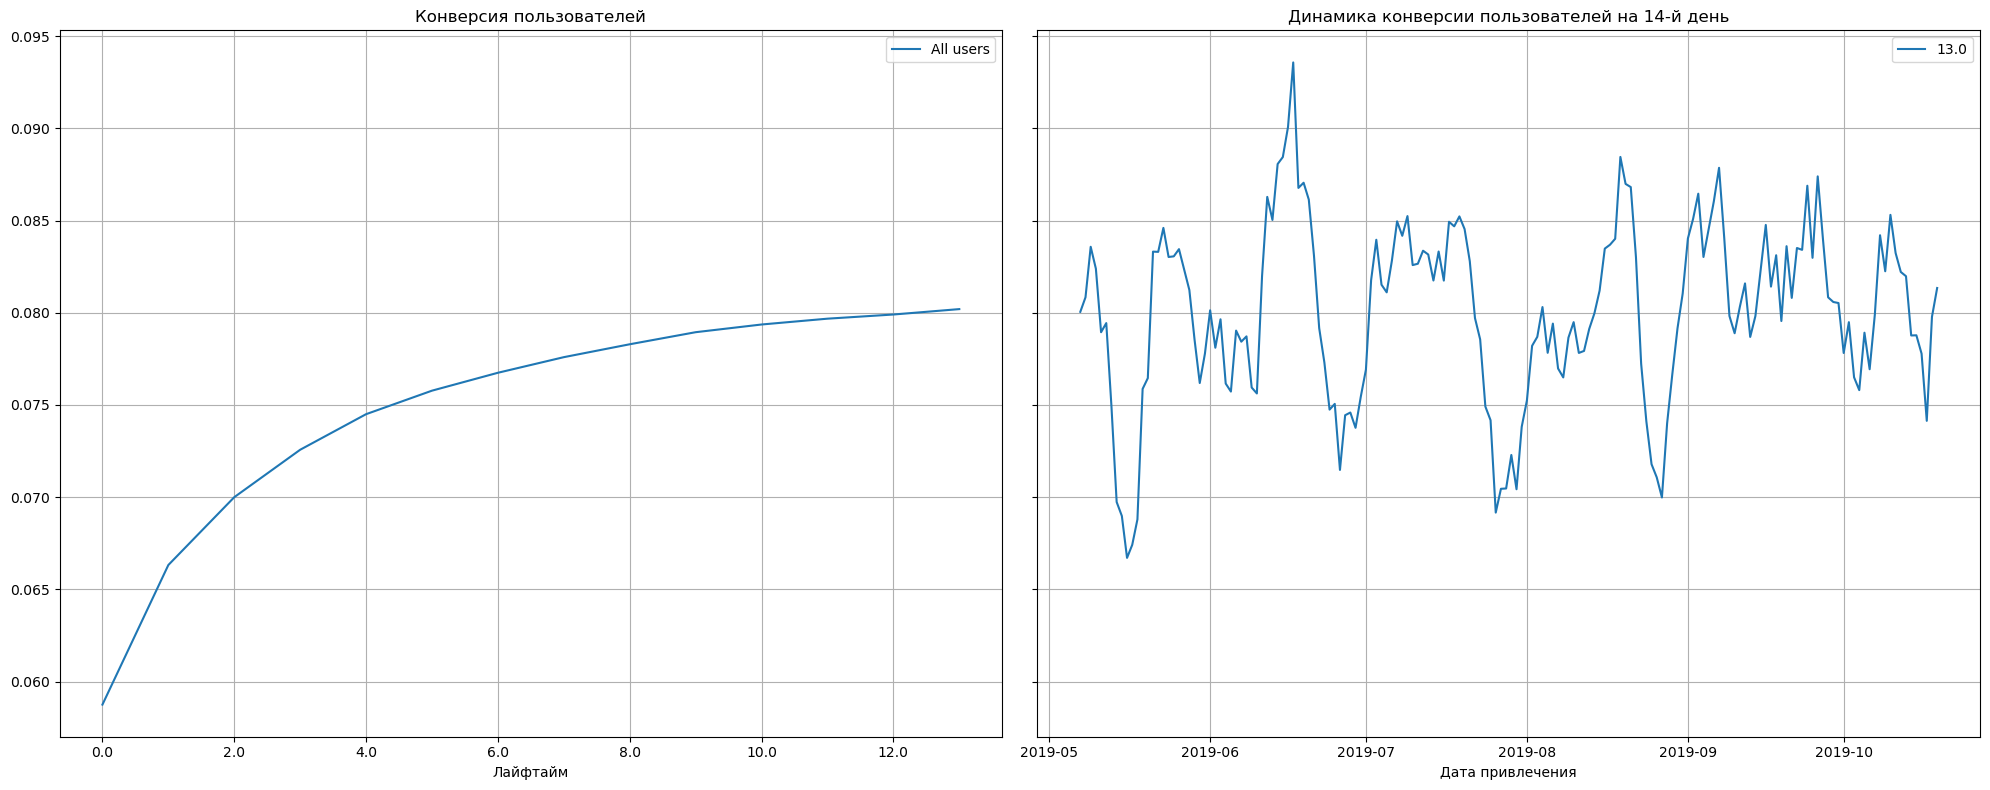

In [36]:
# смотрим конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия происходит только для 8% пользователей. При этом динамика конверсии в течение всего времени имеет нестабильные значения: много резких ростов и спадов.

Посмотрим на удержание пользователей:

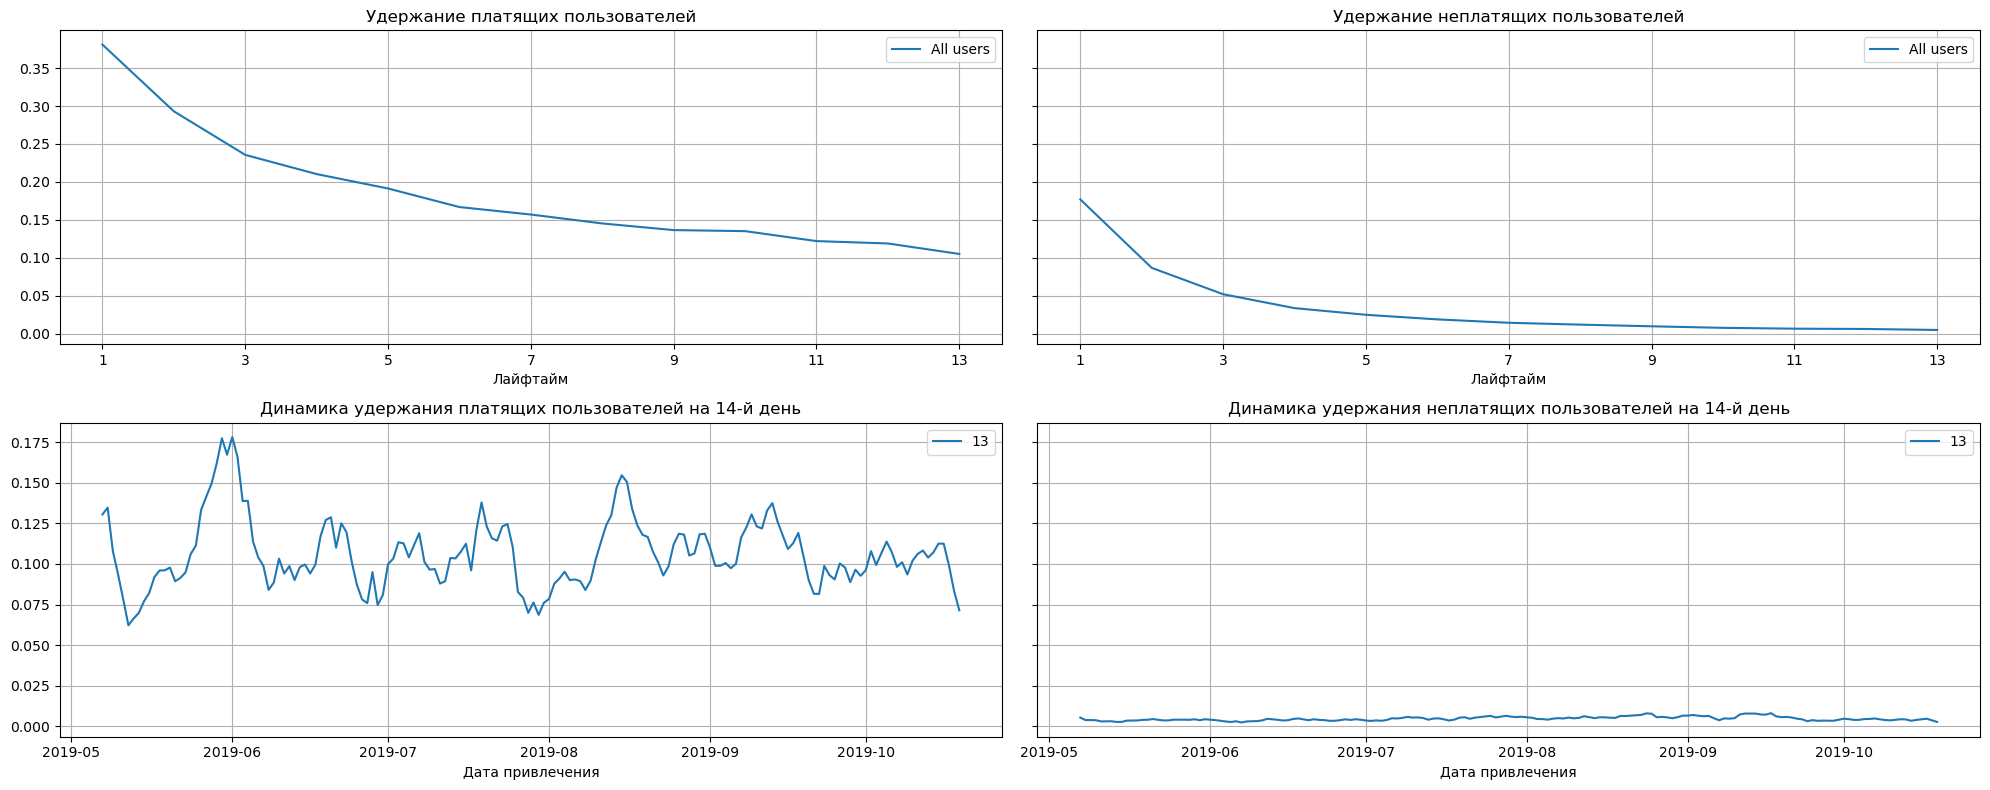

In [37]:
# смотрим удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

К концу лайфтайма неплатящие пользователи практически не остаются в приложении, а из платящих остаётся только 10%. При этом динамика удержания платящих пользователей на протяжении всех рассматриваемых времён находится на уровне 10%, но при этом имеет колебание в значениях каждый месяц.

### Окупаемость рекламы с разбивкой по устройствам

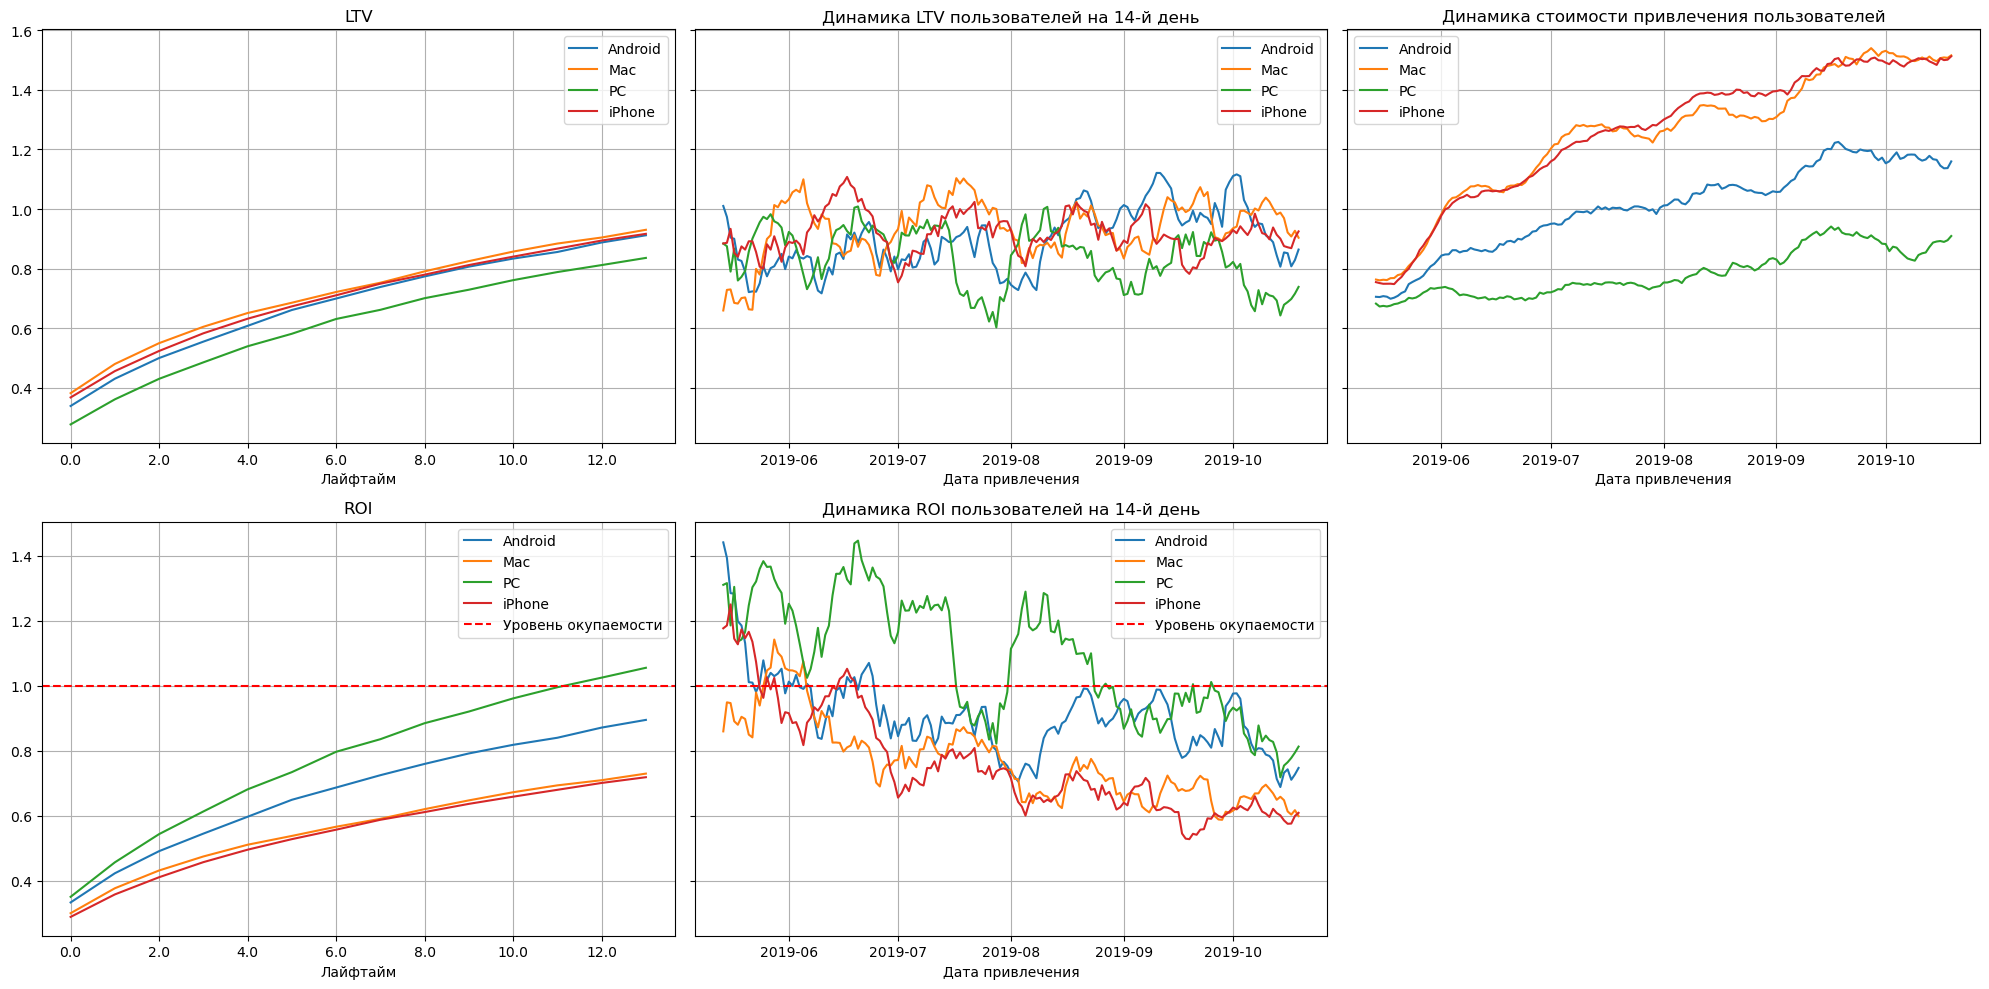

In [38]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Из графиков видно, что:
- Для разных устройств LTV практически не оличается: плавный рост на протяжении лайфтайма выше 80%.
- Динамика LTV для разных устройств схожа между собой и мало зависит от сезона.
- Стоимость привлечения пользователей наиболее высокая для Мака и айфона, а для ПК наименьшая
- Наименьший ROI для Мака и айфона (в конце лайфтайма дошёл до 70%), а самый высокий у ПК (чуть выше 100%). При этом можно отметить, что окупились только пользователи ПК, а андроид, как и мак с афйоном находится ниже линии окупаемости (90%).
- График динамики ROI ведёт себя схоже для всех устройств: ROI падает с мая и до ноября. Но при этом для ПК он держится выше 100% почти всё время привлечения пользователей, ниже линии стал находиться только с сентября по октябрь. Для айфона и мака это падение произошло в середине июня (причём, для них падение ниже окупаемости с июля и до конца). ROI для андроида сильно просел в августе, к сентябрю более-менее выровнялся, но выше линии окупаемости не поднимался.

Можно отметить, что все устройства, кроме ПК, не окупаются. Но, в целом, разные показатели для этих устройств ведут себя схожим образом, поэтому нельзя отметить однозначную связь между проблемой с плохой окупаемостью рекламы и типом устройства.

Посмотрим для разных устройств конверсию и удержания, чтобы попробовать обнаружить причину проблемы с окупаемостью.

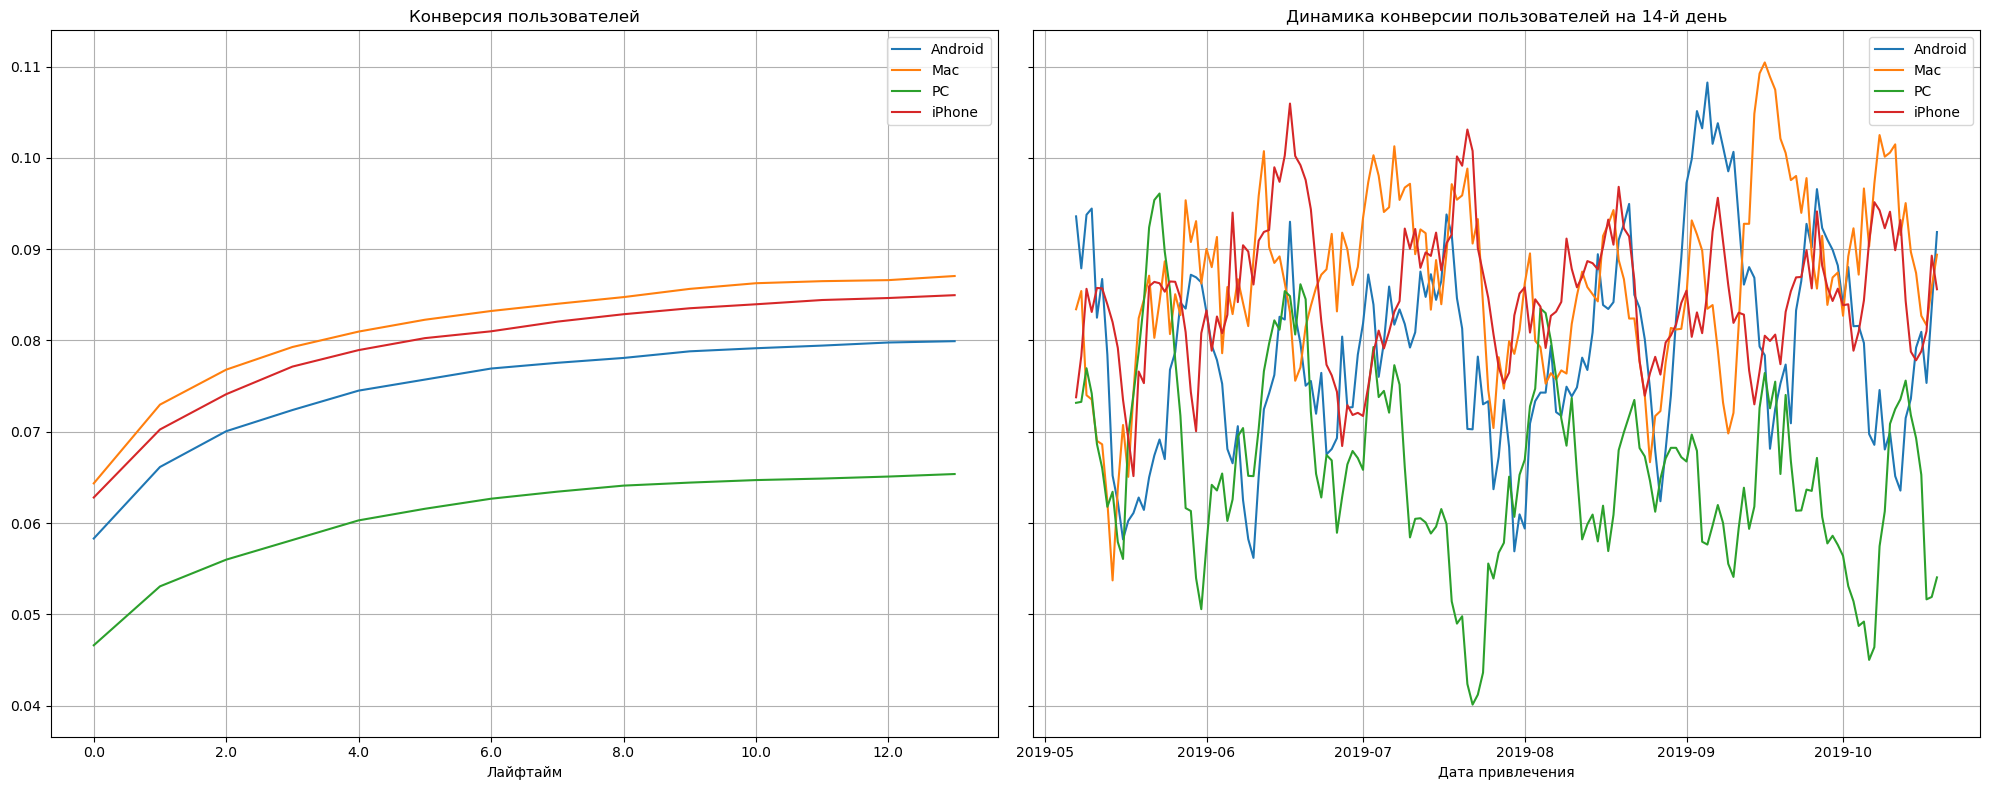

In [39]:
# смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия для мака, айфона и андроида схожи между собой и вполне неплохая и стабильная.

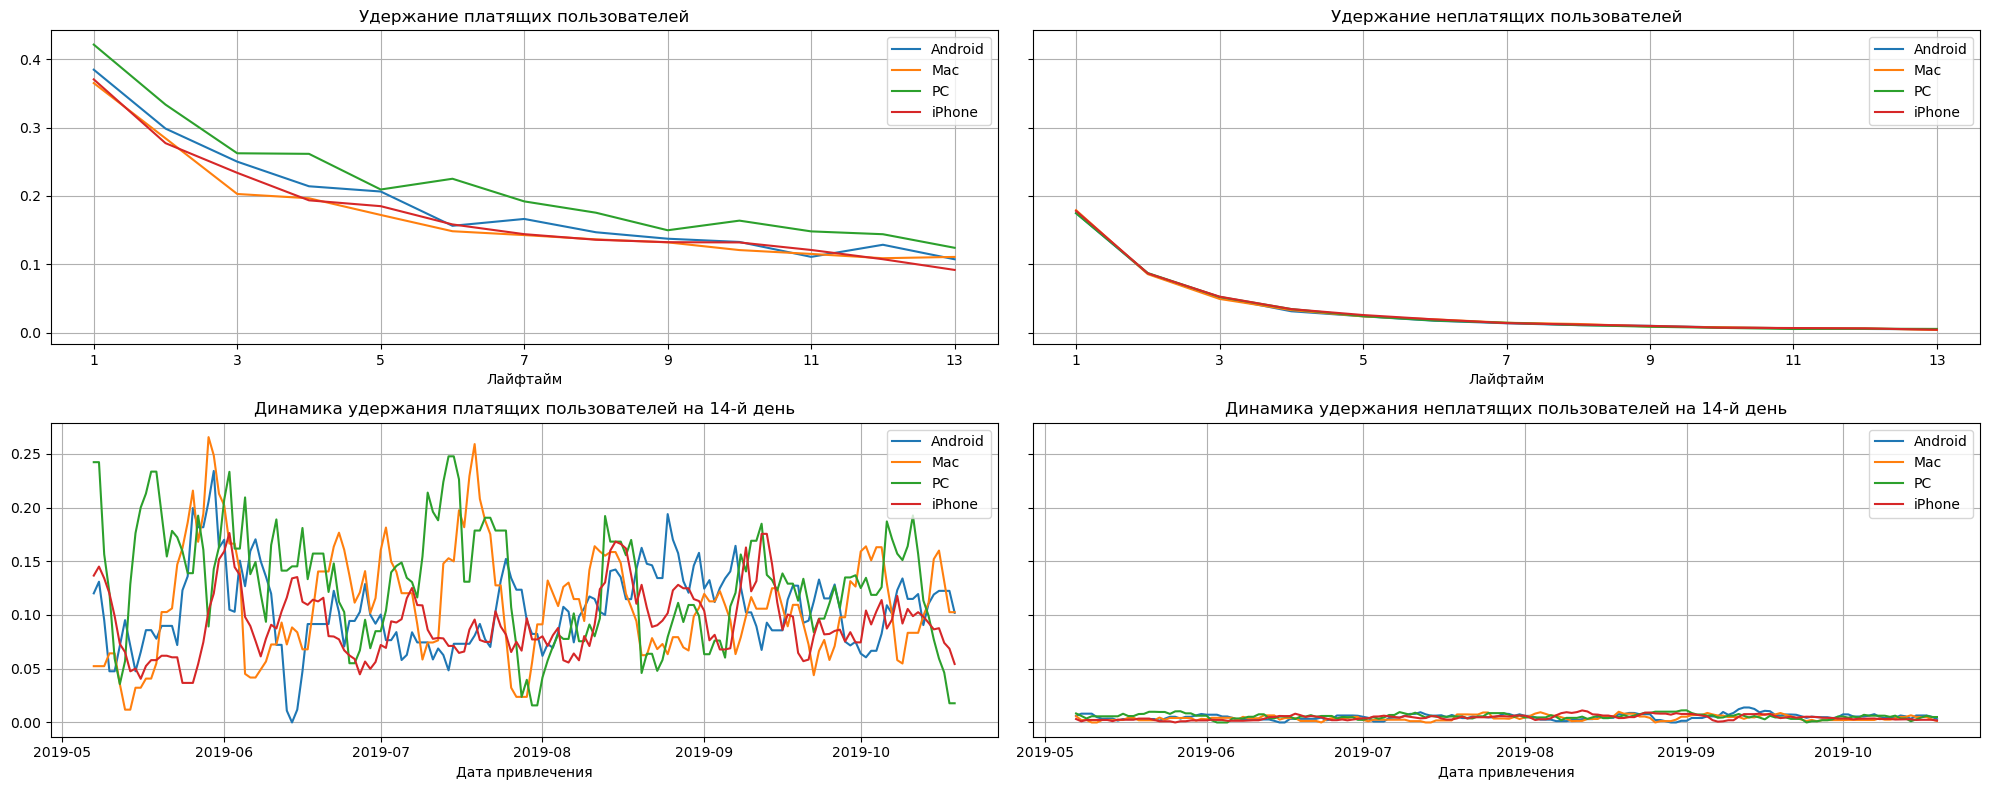

In [40]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание для разных устройств очень схоже. Если бы были технические проблемы, это бы сказалось на удержании. Значит, дело не в этом.

### Окупаемость рекламы с разбивкой по странам

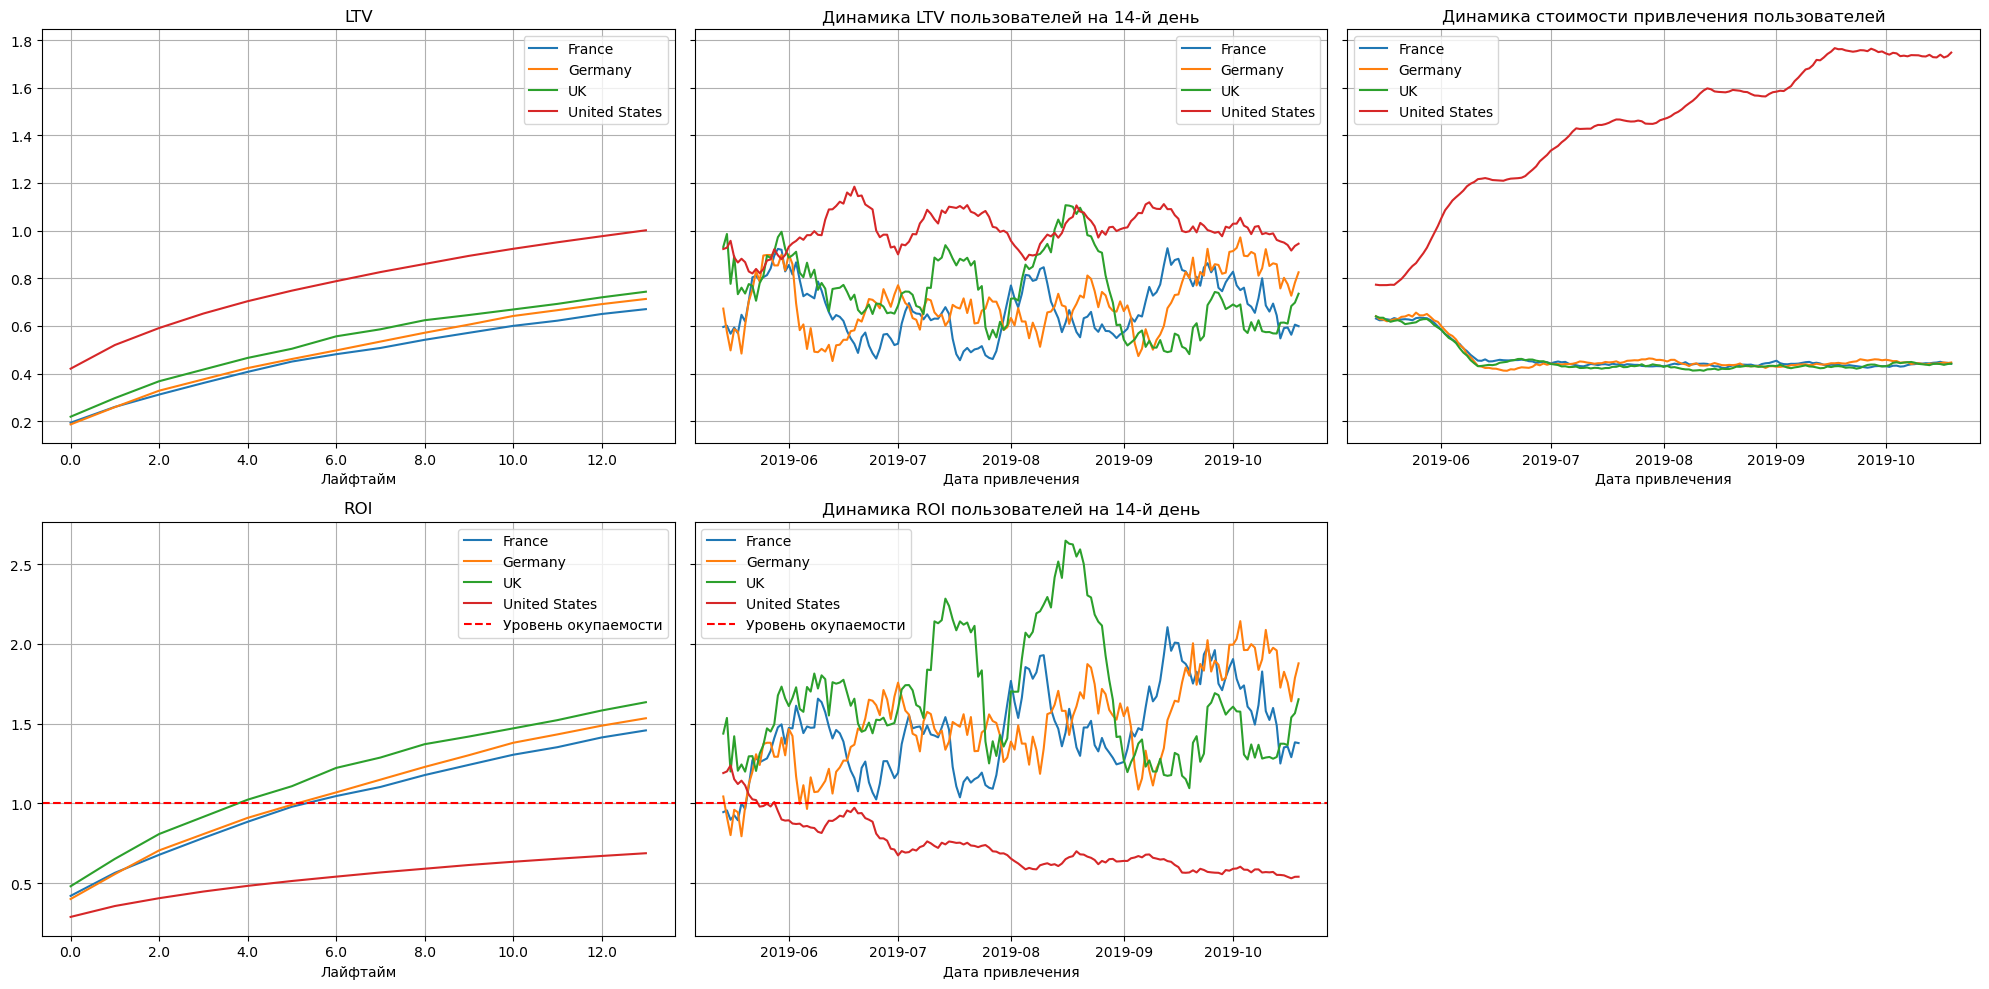

In [41]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Из графиков видно, что:
- LTV плавно растёт для всех стран на протяжении всего лайфтайма, лучше всего показатель у США (LTV достиг отметки в 100%, а у остальных он находится в области 75%).
- Динамика LTV также лучше всего у США, меньше всего колебаний по месяцам. Наиболее нестабильная динамика у Великобритании: много резких скачков и спадов.
- Также можно отметить, что именно для США очень сильно возрастает CAC, для остальных стран стоимость привлечения стабильная, и даже после июня снизилась по сравнению с маем.
- При этом для США не окупается реклама, так как ROI для этой страны ниже всех остальных и находится в области 70%, в то время, как для остальных стран, окупаемость рекламы произошла (ROI почти 150%).
- Из графика динамики ROI также видно, что для всех стран, кроме США, ROI выше 100%, хотя и наблюдается периодически скачки в показателе, которые согласуются со скачками LTV. А вот для США ROI стабильно падает с мая и до ноября, а с июня и до конца рассматриваемой даты выше 100% не поднималась.

Можно отметить, что США сильно снижает общие показатели метрик. Затраты на привлечение новых пользователей для этой страны сильно выше, чем для остальных, а окупаемости при этом нет. Остальные страны имеют положительные тенденции по окупаемости.

Посмотрим для разных стран конверсию и удержание, чтобы попробовать обнаружить причину проблемы с окупаемостью.

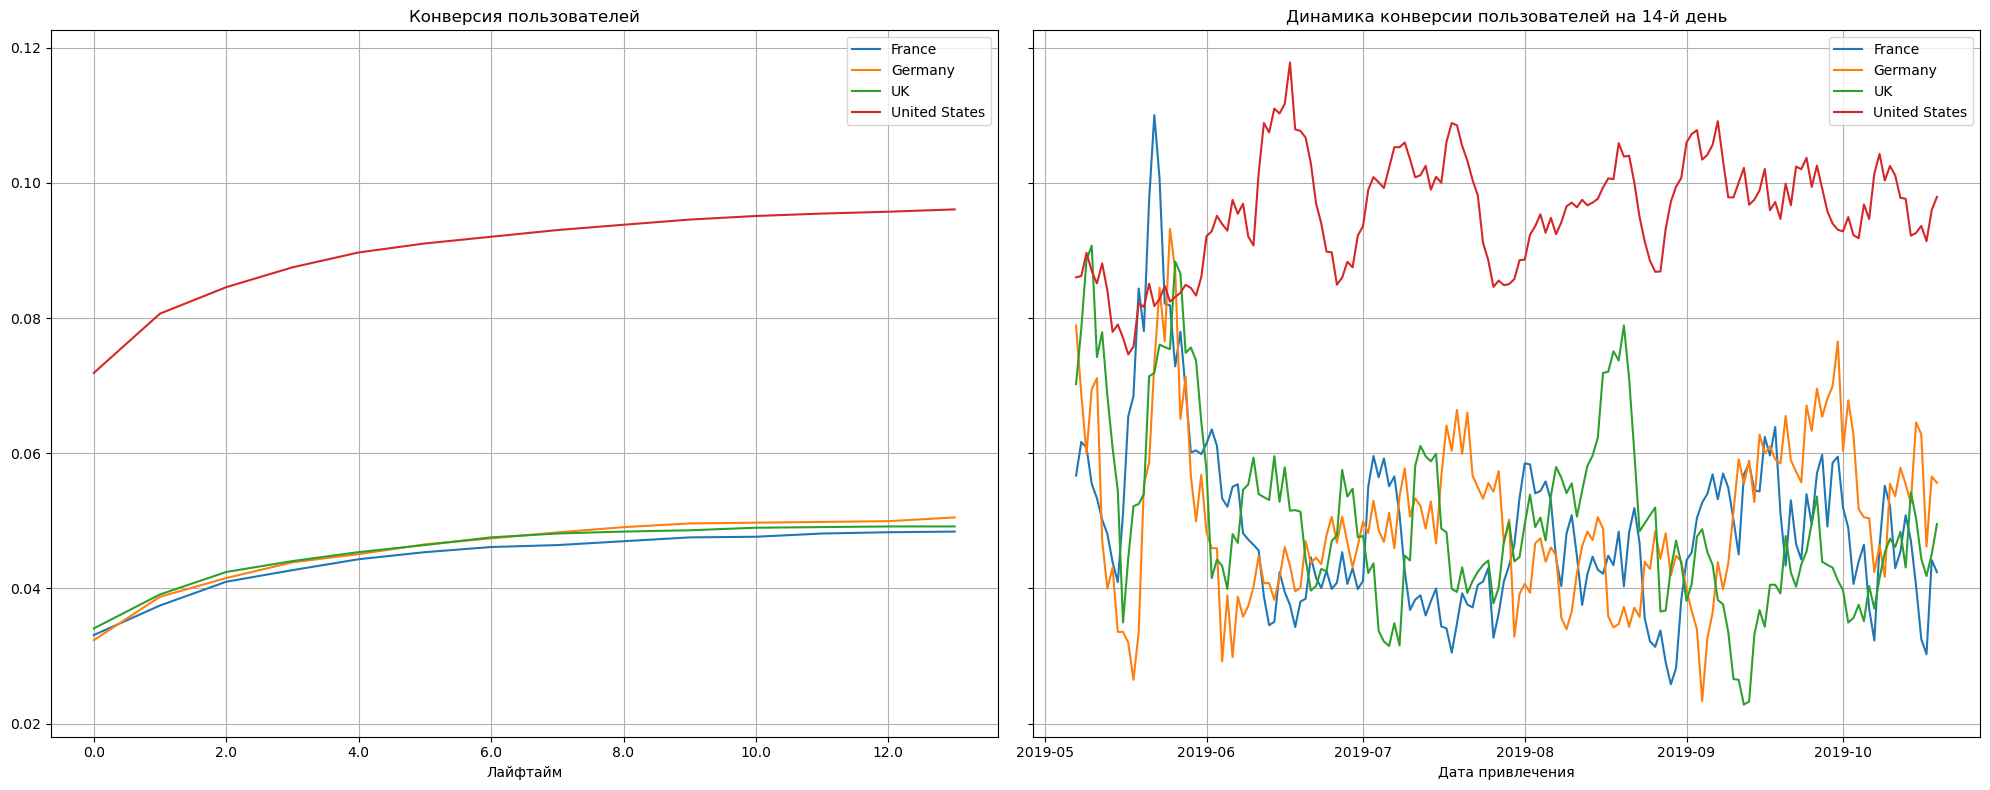

In [42]:
# смотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия пользователей для США наибольшая - 10%, а для остальных стран находится на уровне 5%. При этом график динамики конверсии для США также показывает стабильные значения на протяжении всего рассматриваемого периода.

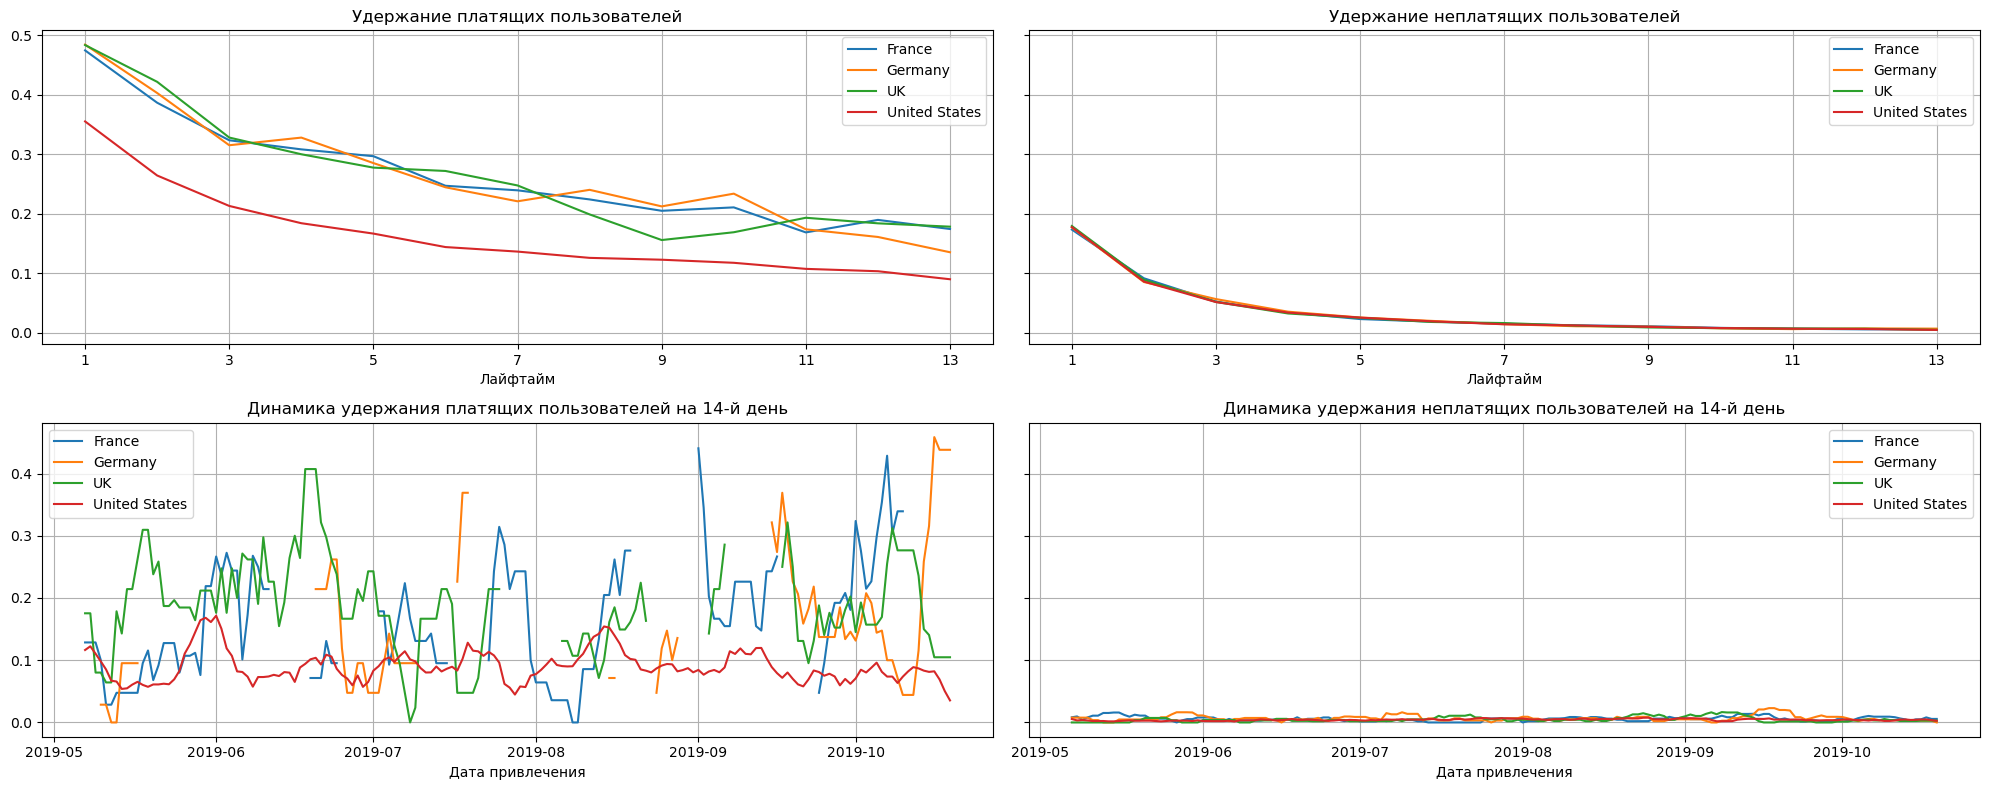

In [43]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

При этом удержание платящих пользователей для США хуже, чем для других стран и находится на уровне 10%.

### Окупаемость рекламы с разбивкой по каналам

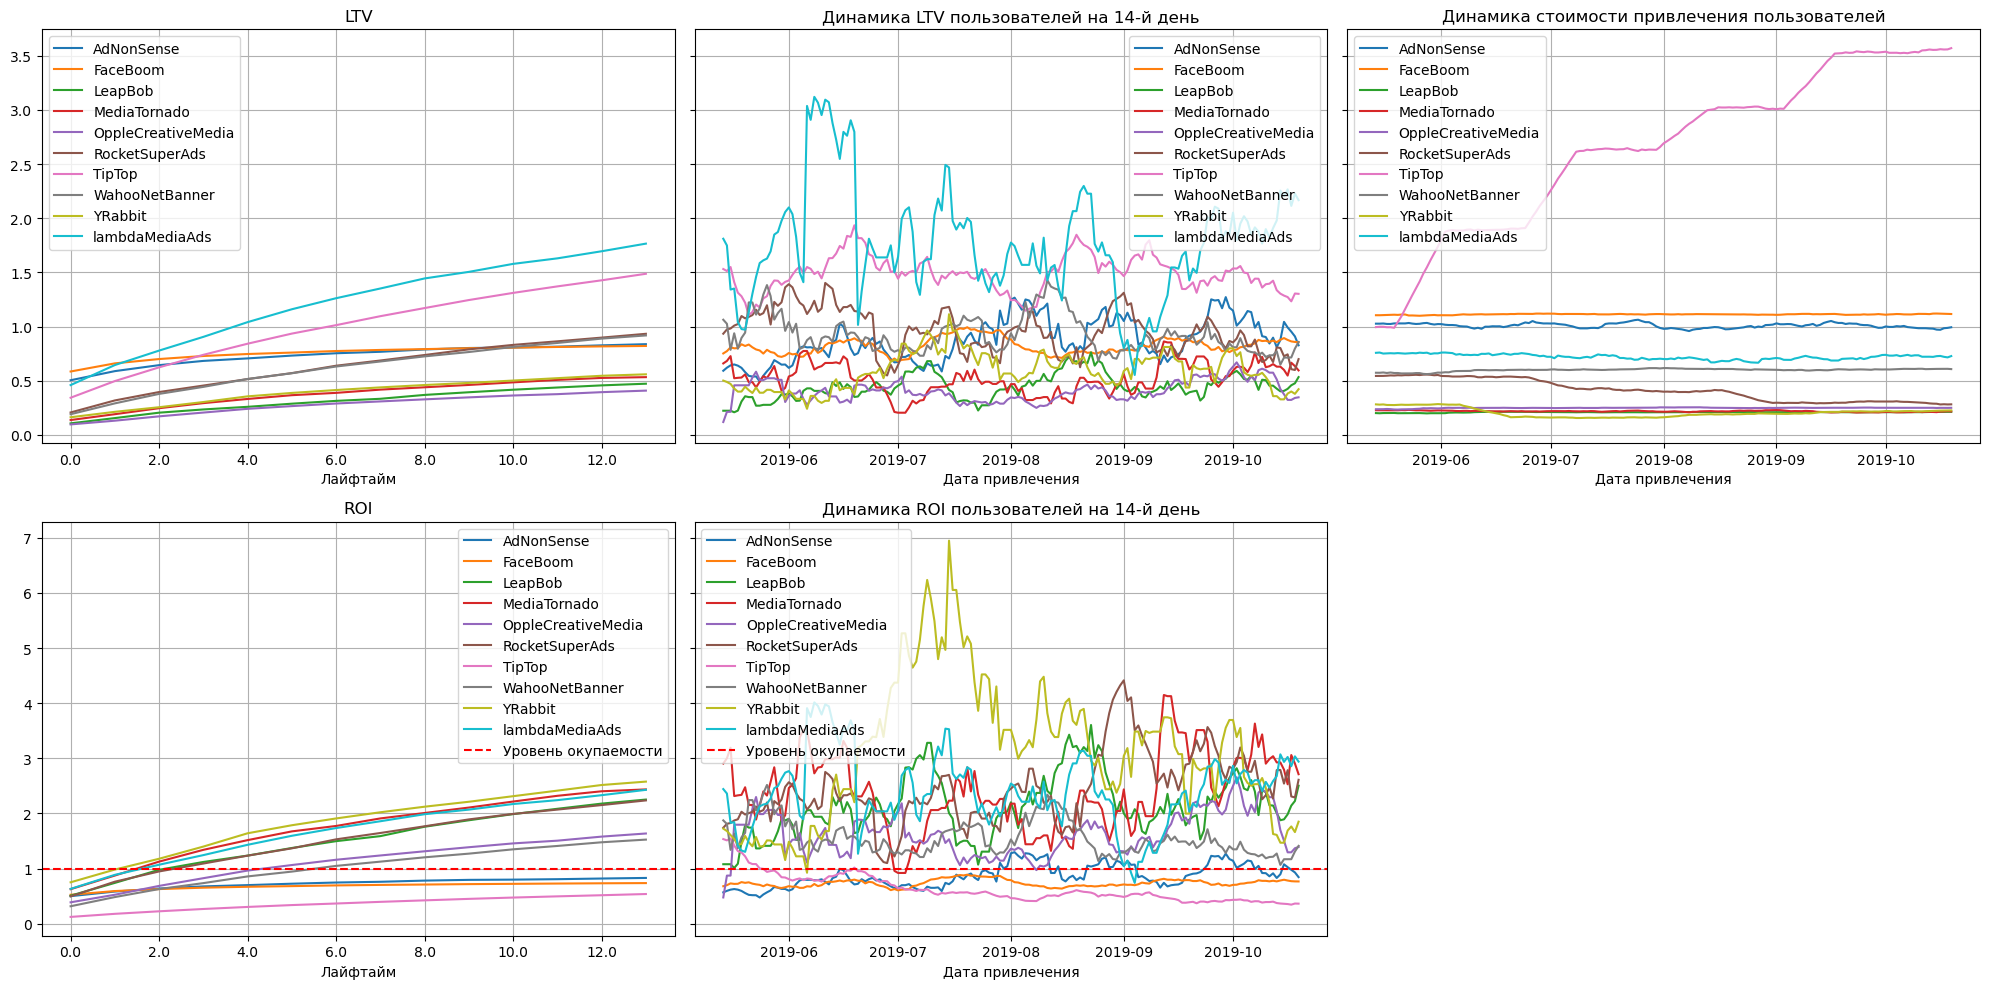

In [44]:
# смотрим окупаемость с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
             ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
            ) 

Из графиков видно, что:
- Затраты на привлечение пользователей из канала TipTop являются необоснованно дорогими: для этого канала нет окупаемости на протяжении всего времени привлечения
- Также всё время ниже уровня окупаемости находится канал FaceBoom, несмотря на высокую долю платящих пользователей по этому каналу.
- Самые стабильные показатели у канала YRabbit: наименьшая CAC и наибольшая окупаемость (почти 300% к концу лайфтайма). Но при этом у этого канала наблюдается необоснованный большой всплеск в метрике ROI с июля по август. А также весьма маленькая привлечённая аудитория (всего 4.5 тыс пользователей).

Можно отметить, что канал TipTop является самым проигрышным каналом для привлечения пользователей: нет окупаемости в течение всего периода, а стоимость привлечения пользователей самая высокая и постоянно растёт. Также можно отметить неокупаемость канала FaceBoom. И это при том, что именно на эти два канала ушло 80% рекламного бюджета.

Для остальных каналов кардинальной разницы в показателях не наблюдается.

Посмотрим для разных источников конверсию и удержание, чтобы попробовать обнаружить причину проблемы с окупаемостью.

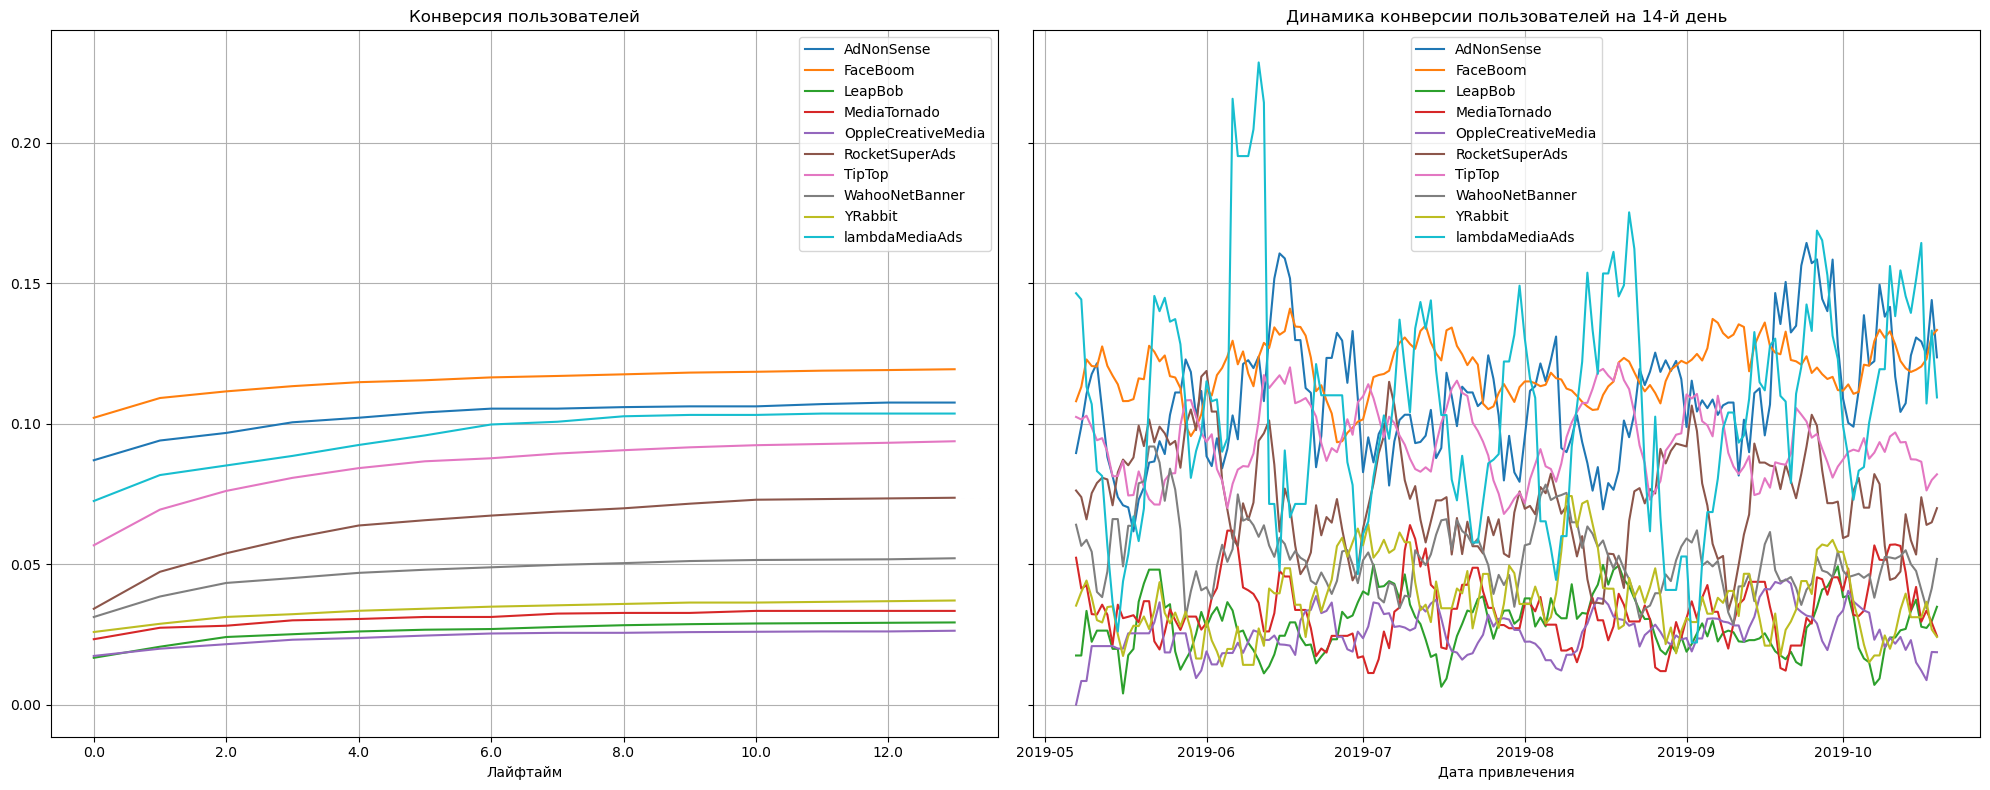

In [45]:
# смотрим конверсию с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Каналы TipTop и FaceBoom имеют схожее между собой поведение динамики конверсии пользователей по месяцам. А общая конверсия у них на уровне 10%. Но в целом, конверсия для всех каналов привлечения ведёт себя схожим образом, просто для части каналов она всё время находится ниже уровня в 5%.

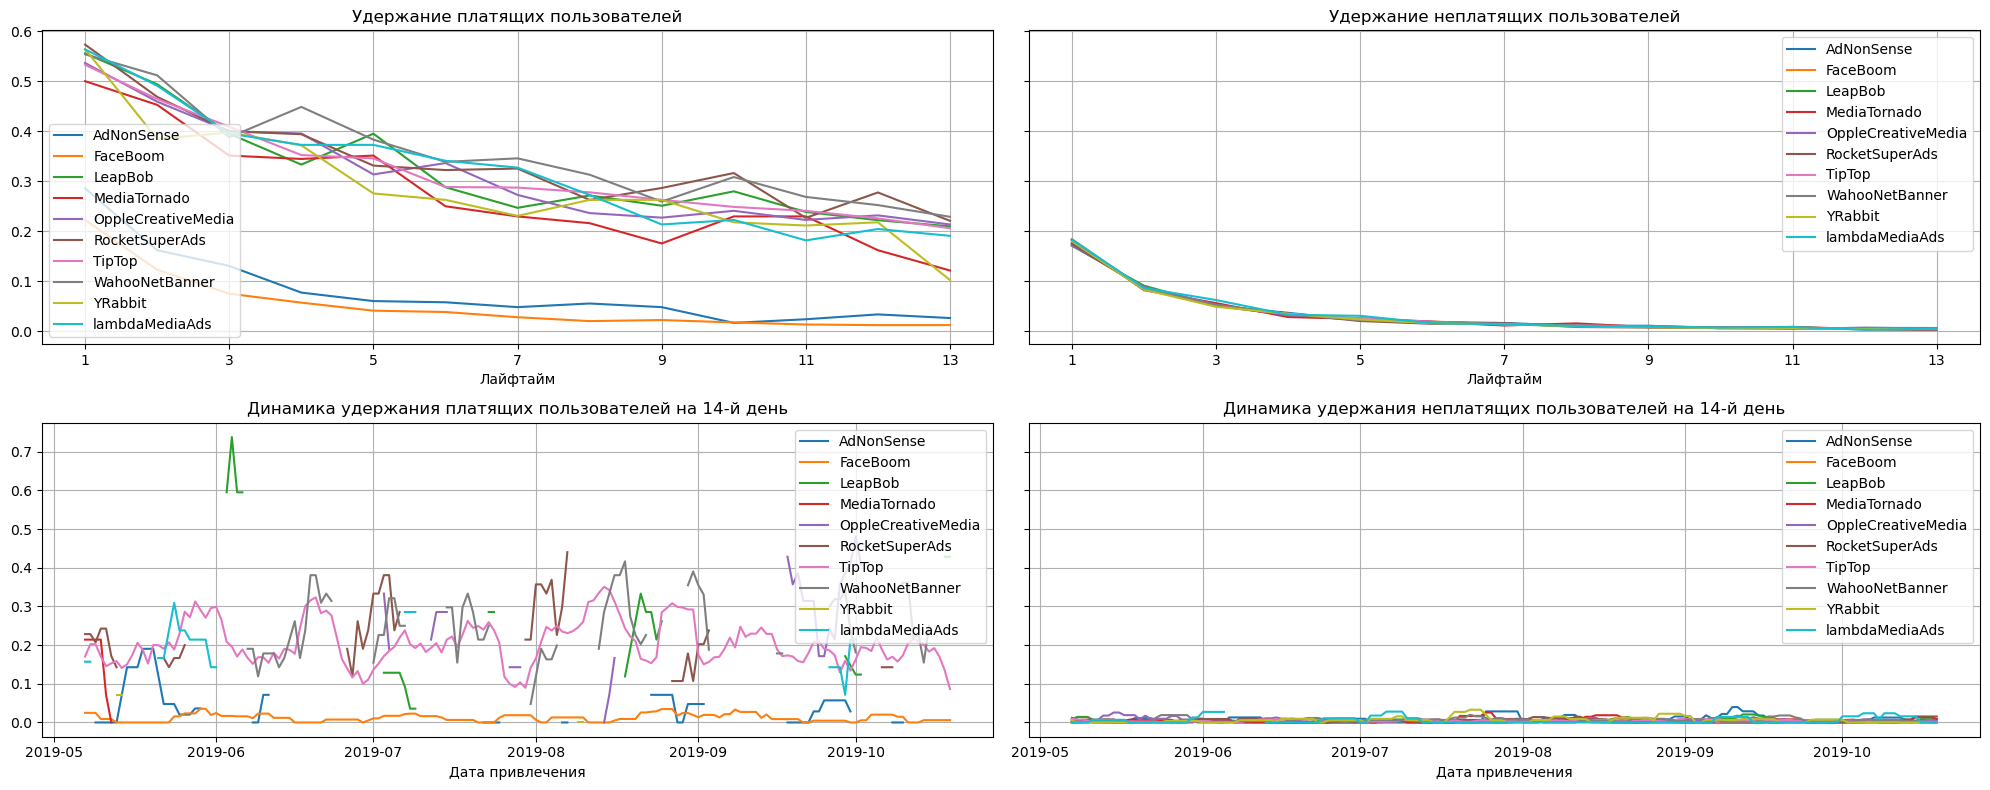

In [46]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот на графиках с удержанием пользователей появились явные провальные каналы: AdNonSence и FaceBoom. Для этих каналов удержание платящих пользователей стремится к нулю. TipTop по удержанию платящих пользователей находится на довольно стабильном уровне. Таким образом можно отметить проблемы для канала FaceBoom. По какой-то причине пользователи, пришедшие через этот канал привлечения, не хотят оставаться в приложении даже после оплаты сервиса.

### Проверка убыточных каналов

#### Пользователи США

Так как было получено, что полоьзователи из США занижают общую статистику и при этом именно пользователи из США составляют около 50% пользователей приложения, то было решено рассмотреть эту аудиторию более подробно.

In [47]:
profiles_usa = profiles.query('region == "United States"')

In [48]:
category_payer(profiles_usa, 'device')

Наиболее популярное устройство в США - айфон, а на втором месте находится мак. Но при этом по процентному соотношению платящих пользователей к общему числу пользователей эти два устройства находятся на последних местах. А на первом находится андроид с 10.6% платящих.

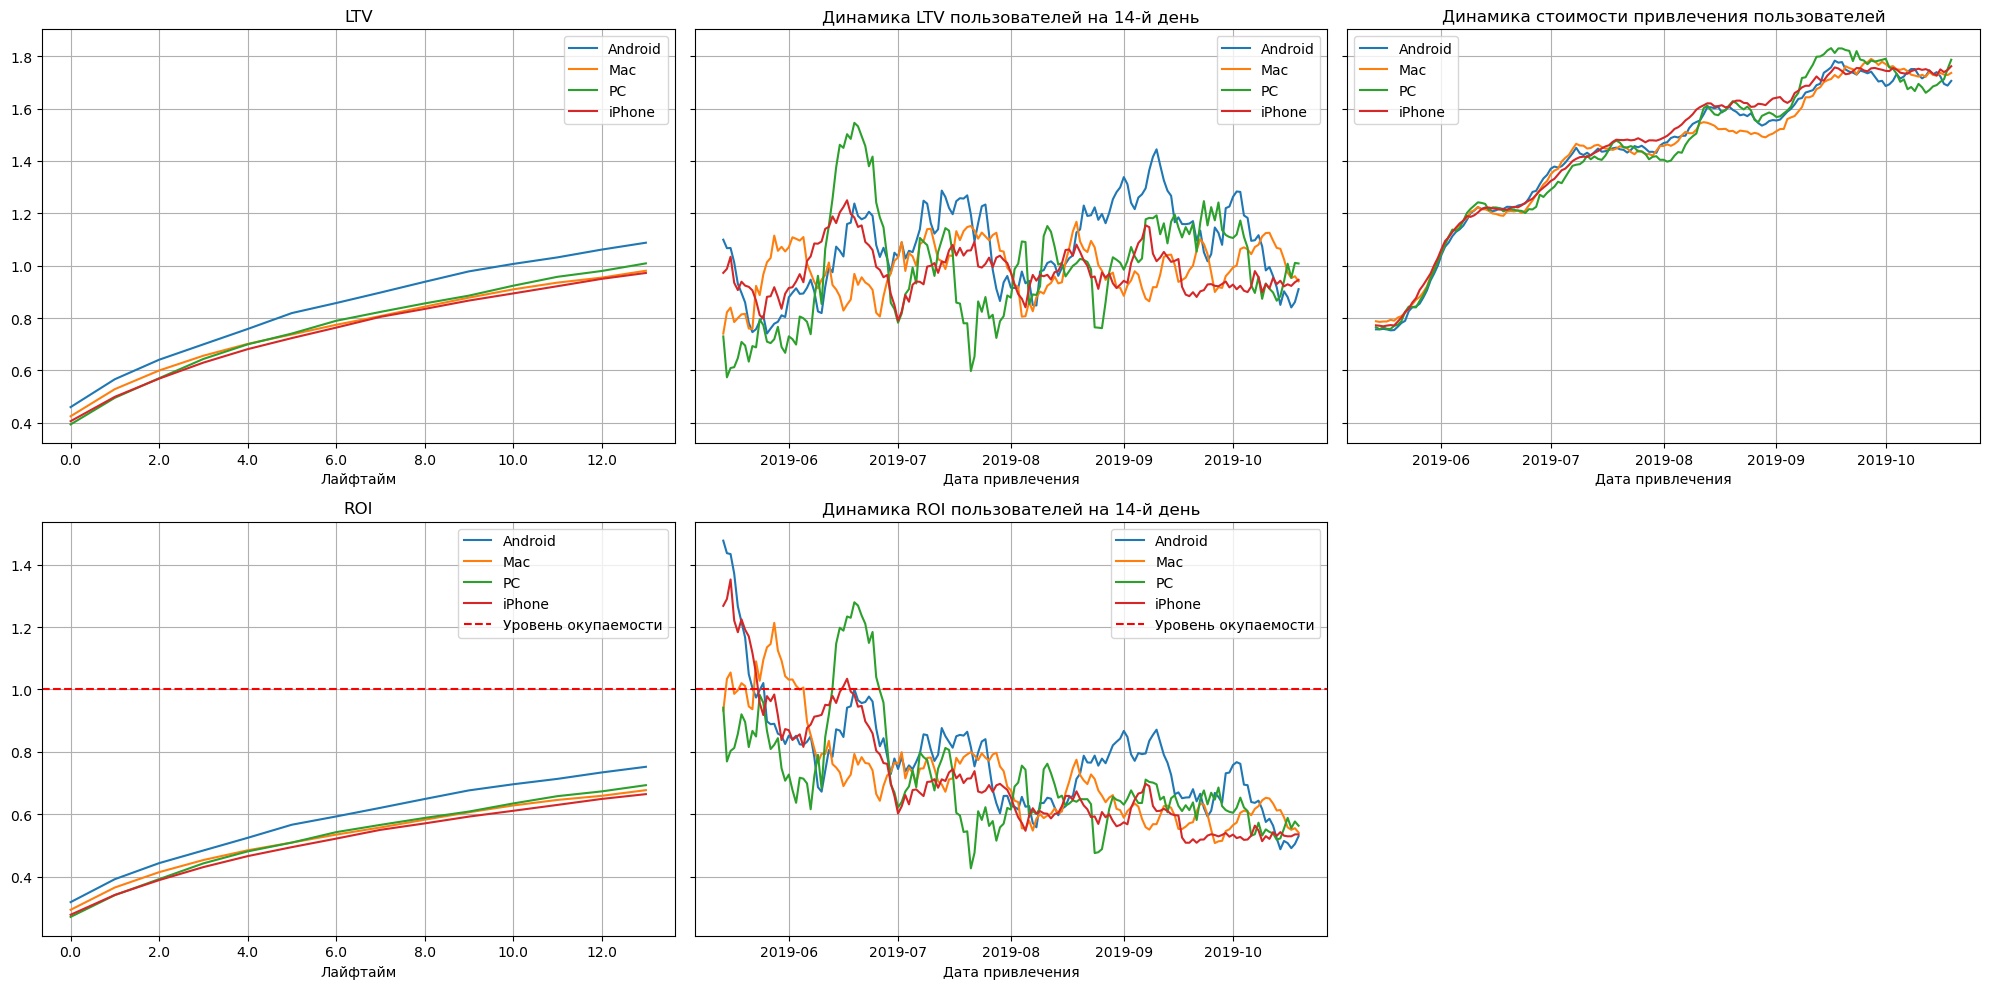

In [49]:
# смотрим окупаемость с разбивкой по каналам для пользователей из США
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Графики для разных устройств для пользователей из США особо ничем не отличаются друг от друга.

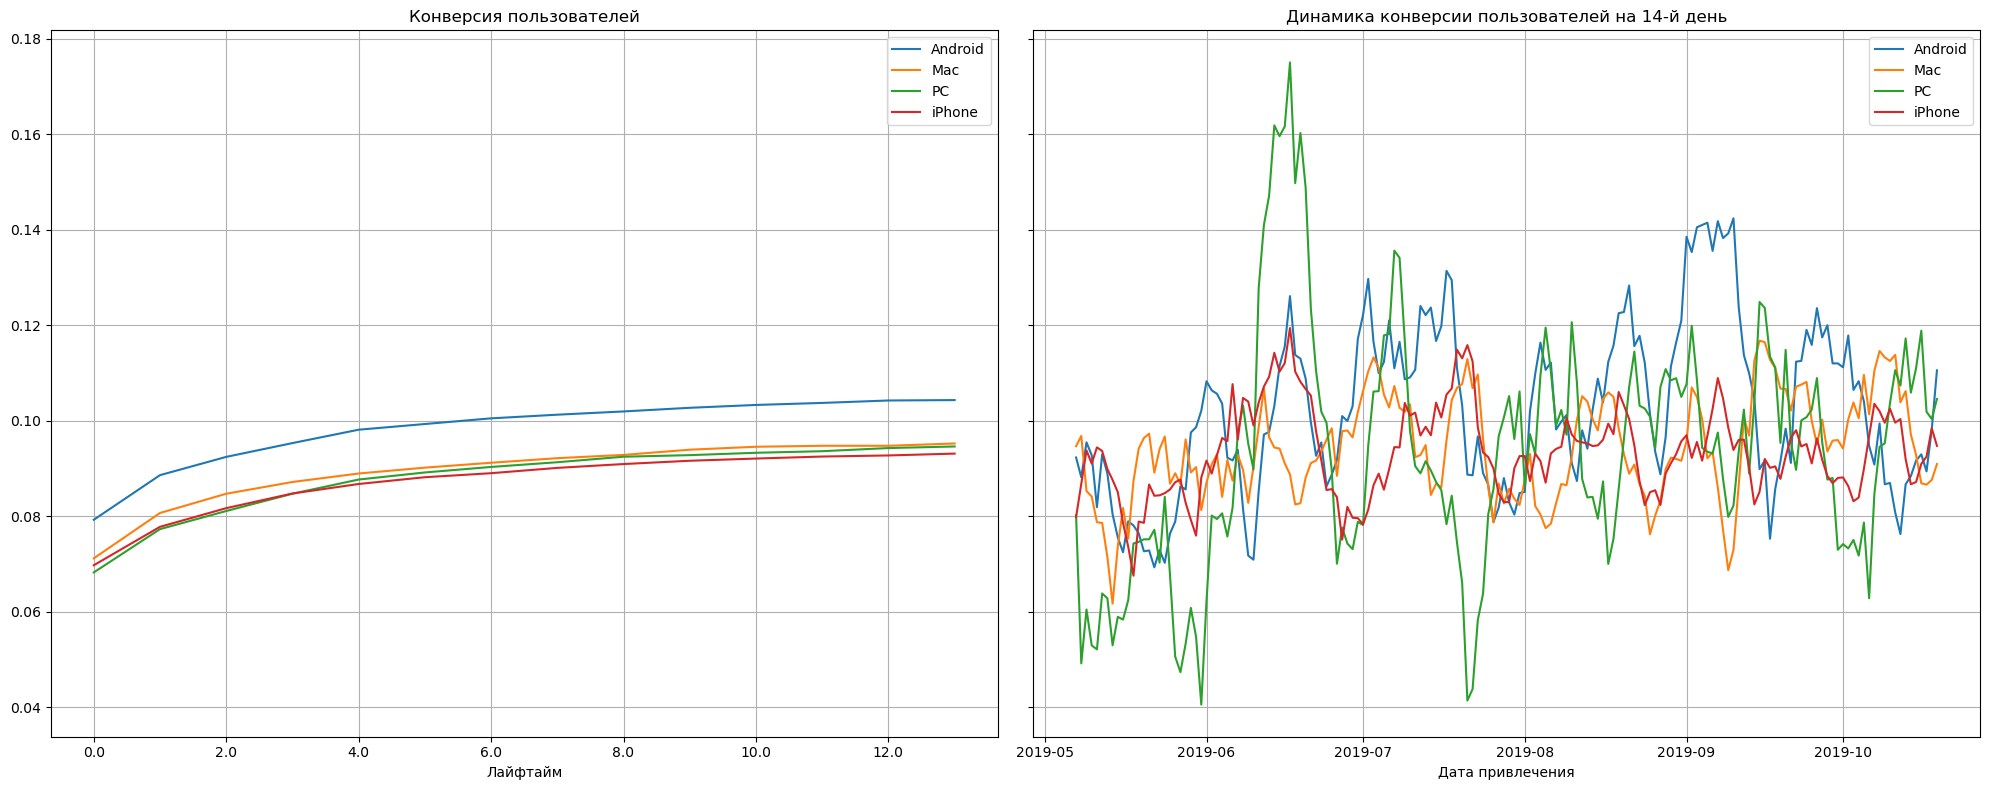

In [50]:
# смотрим конверсию с разбивкой по устройствам для пользователей из США

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Также не наблюдается особой разницы для конверсии для разных устройств.

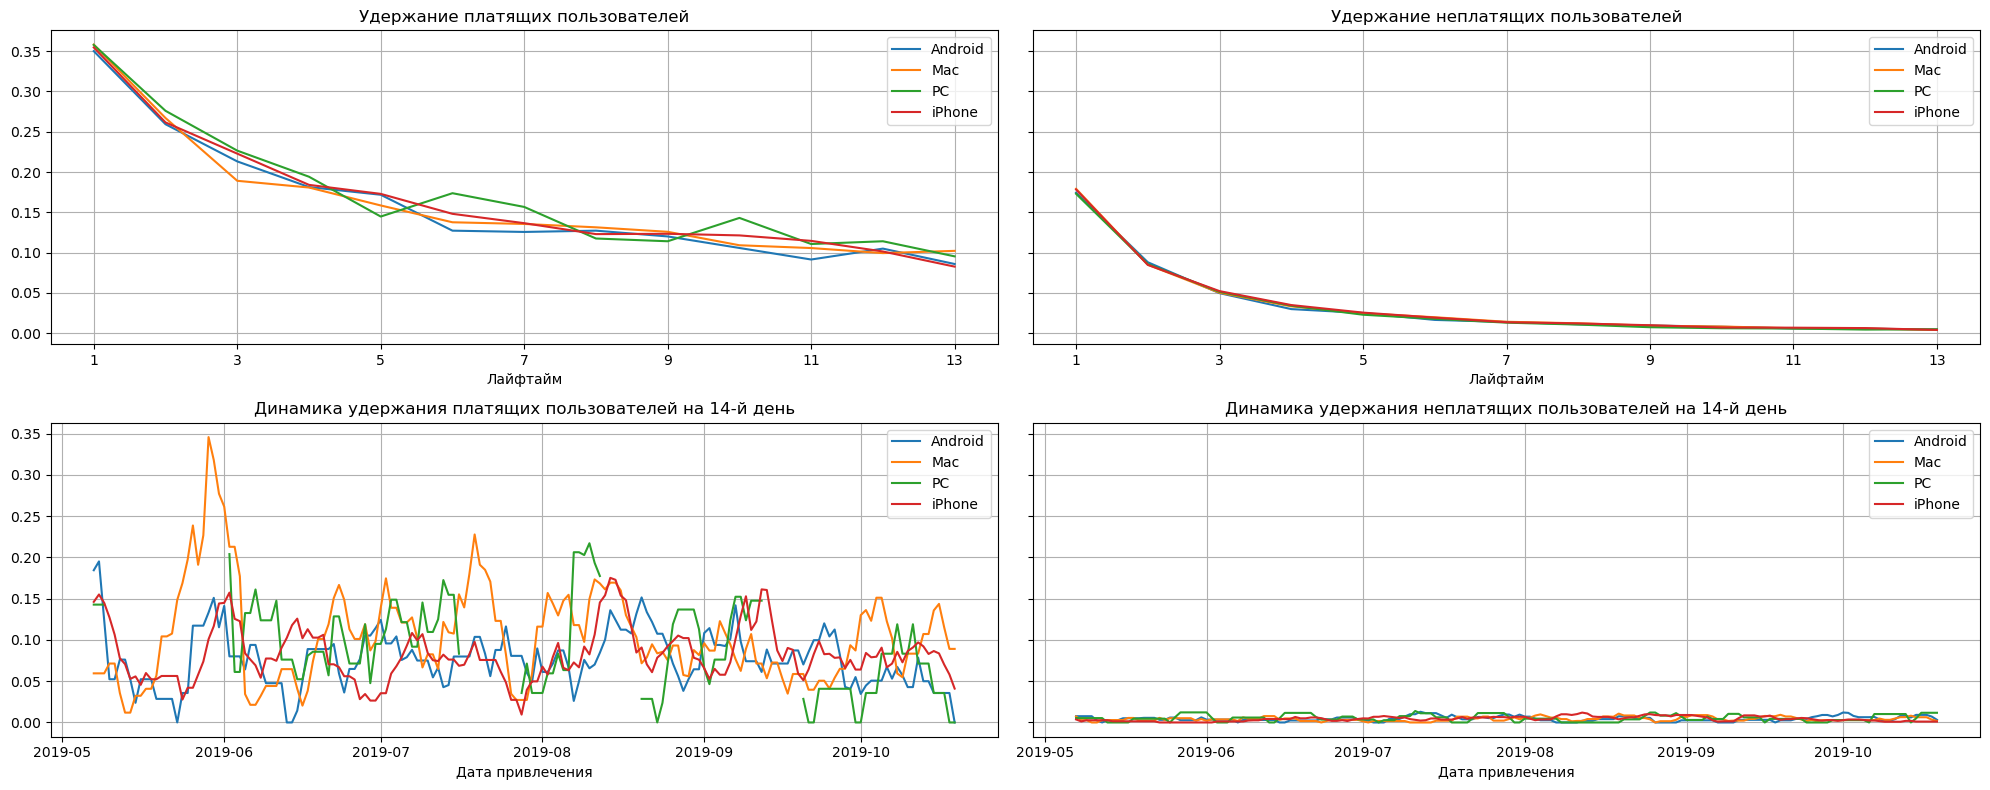

In [51]:
# смотрим удержание с разбивкой по устройствам для пользователей из США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

И нет разницы между удержанием для платящих пользователей. Значит, дело не в том, какое устройство используют граждане США.

In [52]:
category_payer(profiles_usa, 'channel')

Можно отметить, что в США используются всего 5 каналов для привлечения новых пользователей приложения. При этом лидером и по количеству пришедших пользователей и по проценту платящих является FaceBoom. Но посмотрим, кто из небольших каналов привлечения лидирует, так как мы помним, для всего мира FaceBoom и TipTop были убыточными.

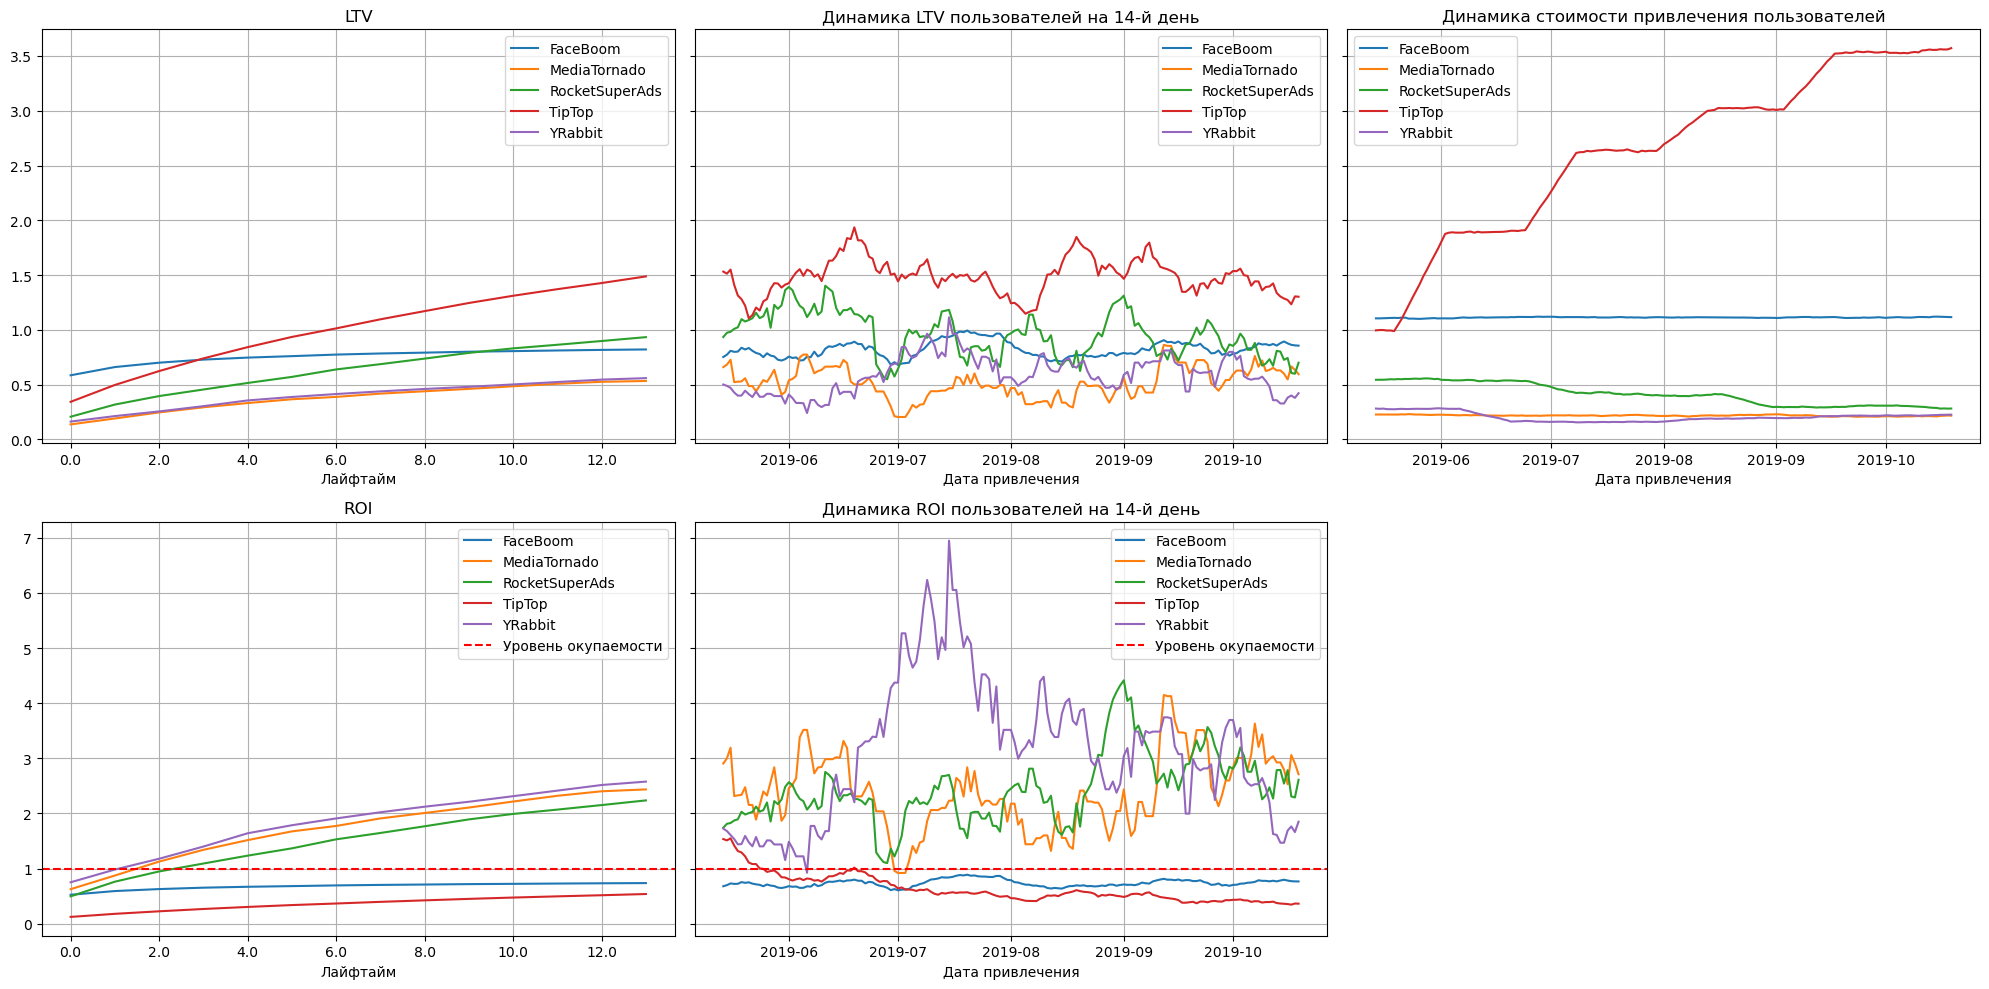

In [53]:
# смотрим окупаемость с разбивкой по каналам для пользователей из США
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Для США есть два убыточных канала привлечения: TipTop и FaceBoom. При этом, как и для пользователей по другим странам, у TipTop нет окупаемости, так как расход бюджета рекламы на этот канал сильно возрастает с каждым месяцем.

Можно отметить положительные по своей динамике каналы привлечения: YRabbit, MediaTornado и RocketSuperAds.

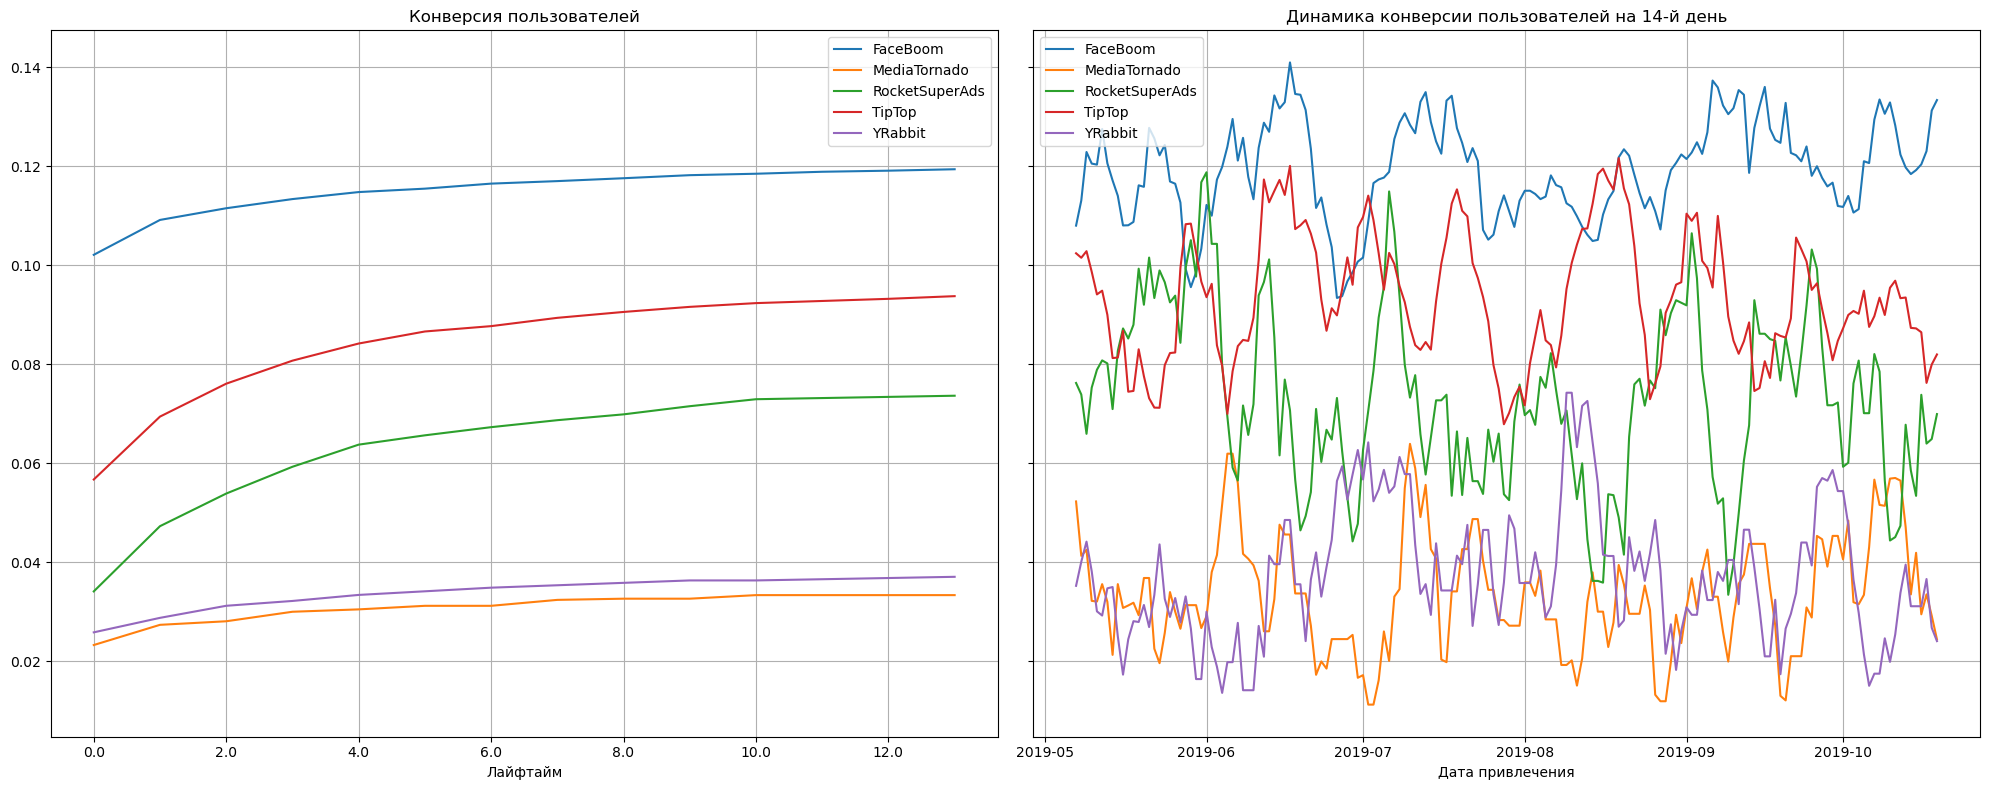

In [54]:
# смотрим конверсию с разбивкой по каналам для пользователей из США

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Для канала RocketSuperAds наблюдается неплохая конверсия пользователей - около 7.5%.

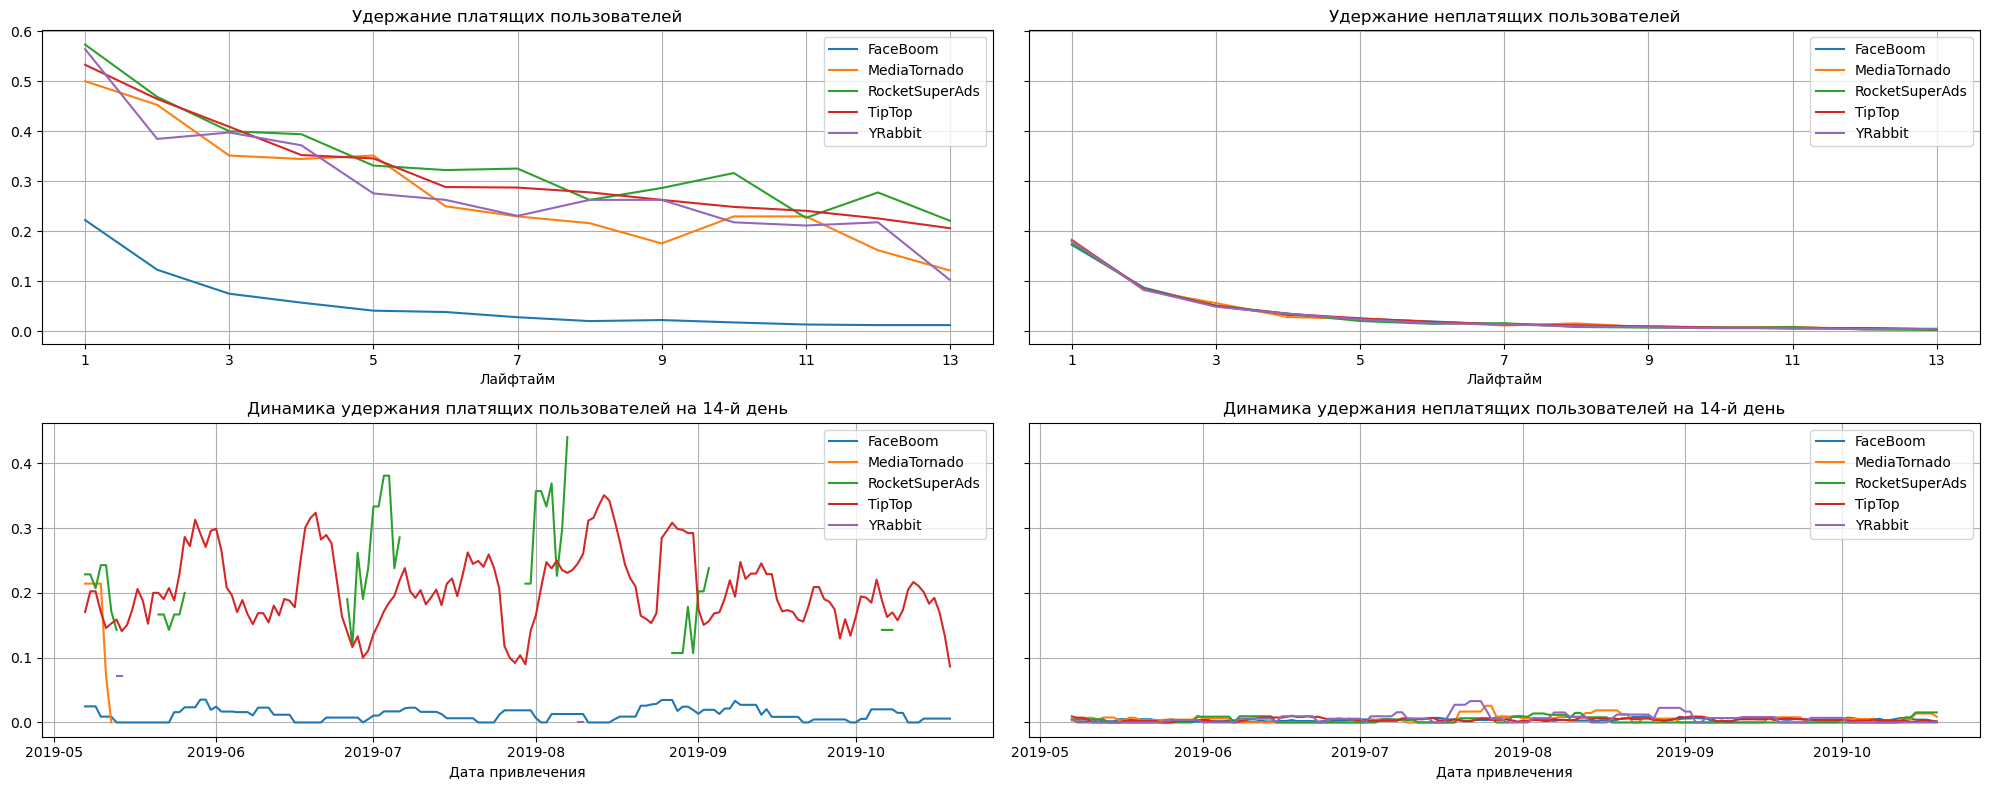

In [55]:
# смотрим удержание с разбивкой по каналам для пользователей из США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Как было на общих графиках для всех пользователей по всему миру, канал FaceBoom является убыточным - удержание пользователей почти на нуле. При этом можно отметить, что канал RocketSuperAds в плане удержания пользователей показывает хорошие результаты.

#### Канал TipTop

Посмотрим подробнее на этот канал привлечения новых пользователей. В каких странах он чаще использовался и для каких устройств.

In [56]:
profiles_tiptop = profiles.query('channel == "TipTop"')

In [57]:
category_payer(profiles_tiptop, 'device')

In [58]:
category_payer(profiles_tiptop, 'region')

Значит, канал TipTop был задействован исключительно в США. При этом устройства пользователей, которые перешли по данному каналу, коррелируют со статистикой устройств в США: наиболее популярные айфон и мак, но при этом по показателям платящих пользователей, они на последнем месте.

#### Канал FaceBoom

In [59]:
profiles_faceboom = profiles.query('channel == "FaceBoom"')

In [60]:
category_payer(profiles_faceboom, 'device')

In [61]:
category_payer(profiles_faceboom, 'region')

И канал FaceBoom тоже был использован исключительно в США. Что, в целом, показывает, что пользователи, которые переходят по этому каналу, либо испытывают какие-то трудности, либо не являются ЦА приложения, так как удержание пользователей по данному каналу практически нулевое.

### Промежуточные выводы:

- Конверсия происходит только для 8% пользователей. При этом динамика конверсии в течение всего времени имеет нестабильные значения: много резких ростов и спадов.
- В приложении происходит удержание 10% платящих пользователей, неплатящие к концу двух недель практически не остаются. При этом динамика удержания платящих пользователей на протяжении всех рассматриваемых времён находится на уровне 10%, но имеет росты и спады каждый месяц.
- В целом, нет окупаемости рекламы, направленной на привлечение пользователей (ROI к концу лайфтайма ниже 100%).
- Стоимость привлечения пользователей наиболее высокая для мака и айфона. При этом пользователи мака и айфона не окупаются. 
- Для ПК наблюдается наиболее стабильная динамика ROI, он почти всё время выше линии окупаемости.
- Стоимость привлечения пользователей из США гораздо выше всех остальных стран и для США нет окупаемости (все остальные страны достигли значения ROI почти в 150%). Динамика ROI для США также наихудшая по всем страна - всё время ниже отметки окупаемости.
- Затраты на привлечение пользователей из канала TipTop являются необоснованно дорогими: для этого канала нет окупаемости на протяжении всего времени привлечения.
- Вторым по необоснованной дороговизне канала является FaseBoom, он также не окупается. К тому же для этого канала удержание пользователей находится на нуле.
- На каналы TipTop и FaseBoom ушло более 80% рекламного бюджета.
- Самые стабильные показатели у канала YRabbit: наименьшая CAC и наибольшая окупаемость (почти 300% к концу лайфтайма). Но при этом у этого канала весьма маленькая привлечённая аудитория.
- Можно отметить канал RocketSuperAds, так как в США у этого канала были неплохие показатели для страны, в то время, как TipTop и FaseBoom для США, как и для остальных стран, были убыточные.

Проблемы окупаемости могут быть вызваны, к примеру, техническими проблемами в приложении. Так как больше всего провалов с окупаемостью наблюдается для пользователей из США и для пользователей маков и айфонов (наиболее популярные и доступные устройства в США). Именно на привлечение этой аудитории стоит обратить внимание, так как стоимость их привлечения растёт от месяца к месяцу, а результата нет.

Наиболее провальными в плане рекламной компании оказались каналы `FaceBoom` и `TipTop`, так как на эти каналы было направлено более 80% общего рекламного бюджета, а окупаемости они не дали. При этом канал `TipTop` не дал окупаемости, так как расходы на этот канал постоянно возрастали, но удержание платящих пользователей к концу лафтайма было неплохим. А `FaceBoom` не дал окупаемости, так как удержание пользователей для этого канала было на нуле. Можно предположить, что аудитория, которая приходила из этого канала привлечения либо сталкивалась с какими-то техническими проблемами, либо не является ЦА для исследуемого приложения. Возможно, стоит более внимательно заняться этим вопросом.

В качестве рекомендаций можно отметить, что в США есть такой рекламный канал, как RocketSuperAds, у которого за весь рассматриваемый период времени были неплохие показатели по удержанию пользователей, по конверссии и остальным метрикам. Можно попробовать увеличить рекламный трафик для этого канала, чтобы расширить аудиторию за его счёт.

## Итоги исследования:

Было проведено исследование приложения Procrastinate Pro+. Были представлены данные о пользователях данного приложения, привлечённых с 1 мая по 27 октября 2019 года. За этот период, несмотря на привлечение новых пользователей, компания теряла в доходах. Необходимо было проанализировать причины убытков компании за последние несколько месяцев и помочь компании на основе проведённого анализа выйти в плюс.

Перед проверкой гипотез и анализа, данные были подготовлены для корректной работы:
- В таблицах не было пропусков данных.
- В таблице не было явных и неявных дубликатов.
- Столбцы с датами были приведены к соответственному формату.
- Были переименованы названия столбцов согласно принятому стилю.

Далее была проанализирована общая информация о пользователях, такая как: страна проживания, устройство, с которого пользователи заходили в приложения, и каналы привлечения пользователей:
- Больше всего пользователей приходится на США (почти 50% пользователей приложения). 
- В США больше всего платящих пользователей - 7%, а в других странах около 4%.
- Самое популярное устройство среди пользоватлей - айфон.
- Самое популярное устройство среди платящих пользователей - мак, айфон находится на втором месте, а на последнем - ПК.
- Наиболее популярный канал привлечения FaceBoom, также по этому каналу наибольший процент платящих пользователей.

Была проанализирована стоимость привлечения пользователей из разных каналов и динамика изменения расходов за рассматриваемый промежуток времени:
- Больше всего средств было потрачено на канал TipTop, следующее место занимает канал FaceBoom, на все остальные каналы было потрачено в разы меньше денег. На каналы TipTop и FaceBoom было потрачено более 80% рекламного бюджета за весь рассматриваемый период времени.
- Наибольшая стоимость привлечения одного пользователя для канала TipTop (почти 2.8, в то время, как следующий по стоимости привлечения FaceBoom обошёлся в среднем в 1.1), но при этом процент платящих пользователей для этого канала находится на четвёртом месте.
- Наибольшая доля платящих пользователей для канала FaceBoom, при этом стоимость привлечения одного пользователя для этого канала находится на четвёртом месте.
- Наименьшая стоимость привлечения для канала RocketSuperAds, а по проценту платящих этот канал находится на пятом месте.
- Динамика изменения расходов подвержены изменениям были только каналы TipTop и FaceBoom (наблюдается рост с каждым месяцем), для остальных каналов изменений практически нет.

Также была оценена окупаемость рекламы по разным метрикам:
- Конверсия происходит только для 8 % пользователей. При этом динамика конверсии в течение всего времени нестабильна, наблюдается много резких ростов и спадов.
- Происходит удержание только 10% платящих пользователей, а неплатящие пользователи к концу лайфтайма в две недели почти не остаются.
- Динамика платящих пользователей в среднем находится на одном уровне на протяжении всего времени, но имеет росты и спады каждый месяц.
- Окупаемости рекламы, направленной на привлечение пользователей, нет.
- Наиболее высокая стоимость привлечения пользователей для мака и айфона, при этом нет окупаемости этих двух устройств.
- Стоимость привлечения пользователей из США гораздо выше всех остальных стран, при этом только для США нет окупаемости
- Затраты на привлечение пользователей из канала TipTop являются необоснованно дорогими: для этого канала нет окупаемости на протяжении всего времени привлечения.
- Вторым по необоснованной дороговизне канала является FaseBoom, он также не окупается. К тому же для этого канала удержание пользователей находится на нуле.
- Можно отметить канал RocketSuperAds, так как в США у этого канала были неплохие показатели для страны, в то время, как TipTop и FaseBoom для США, как и для остальных стран, были убыточные.

Стоит обратить внимание на рекламный трафик для граждан США и пользователей мака и айфонов, возможно, временно уменьшить расходы на пользователей из этих групп, так как нет окупаемости рекламы. Именно пользователи из этих групп занижают все показатели. 

Наиболее провальными в клане рекламной компании оказались каналы FaceBoom и TipTop, так как эти каналы были задействованы только в США, на эти каналы было направлено более 80% общего рекламного бюджета, а окупаемости не произошло. При этом на TipTop постоянно росли затраты на рекламу, но удержание платящих пользователей к концу лайфтайма было приемлемым, а FaceBoom не дал окупаемости, так как удержание пользователей для этого канала было на нуле. Можно предположить, что аудитория, которая приходила из этого канала привлечения либо сталкивалась с какими-то техническими проблемами, либо не является ЦА для исследуемого приложения. Возможно, стоит более внимательно заняться этим вопросом.

В качестве рекомендаций можно отметить, что в США есть такой рекламный канал, как RocketSuperAds, у которого за весь рассматриваемый период времени были неплохие показатели по удержанию пользователей, по конверссии и остальным метрикам. Можно попробовать увеличить рекламный трафик для этого канала, чтобы расширить аудиторию за его счёт.